# Get the final dataset

**Goal:** this notebook computes the final dataset used in the next part from the raw impact. It combines a lot of knowledge from the [`/analysis/description/first_study`](https://github.com/ElsaB/impact-annotator/tree/master/analysis/description/first_study) folder to filter, clean, curate and annotate the raw dataset. The final annotation kept is the one from VEP. All the operations made are stored in the [`compute_final_dataset.R`](https://github.com/ElsaB/impact-annotator/blob/master/data/utils/compute_final_dataset.R) file, and can be applied on the raw dataset by using the `get_final_dataset()` function.

This notebook is divided in 3 parts:
* **1. Get click_annotvcf annotations**
* **2. Adapt the `get_cleaned_impact()` function**
* **3. Process raw features**

In [1]:
source("../../../utils/R/custom_tools.R")
setup_environment("../../../utils/R")

In [2]:
impact <- read.table("../../../data/impact_181105/all_IMPACT_mutations_181105.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [3]:
nrow(impact)

[1] 678332

## Get click_annotvcf annotations

Get the features from `click_annotvcf_IMPACT_mutations_181105.txt` (impact annotated by the click_annotvcf pipeline).

### Get the raw data

In [4]:
impact_annotated <- read.table("../../../data/impact_181105/annotate_with_click_annotvcf/click_annotvcf_IMPACT_mutations_181105.txt",
                               sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")

In [5]:
ncol(impact_annotated)
nrow(impact_annotated)
head(impact_annotated)

[1] 156

[1] 465005

ID_VARIANT    TARGET_NAME REFERENCE_NAME CHR START   END     REF ALT
1 1_2487766_T_C NA          NA             1   2487766 2487766 T   C  
2 1_2487944_C_T NA          NA             1   2487944 2487944 C   T  
3 1_2487954_G_A NA          NA             1   2487954 2487954 G   A  
4 1_2487959_T_A NA          NA             1   2487959 2487959 T   A  
5 1_2487984_C_A NA          NA             1   2487984 2487984 C   A  
6 1_2487986_G_A NA          NA             1   2487986 2487986 G   A  
  CONTEXT_5 CHANGE CONTEXT_3 QUAL CALLED_BY PASSED_BY NUMBER_OF_CALLERS
1 TGGAA     C      GGTGC     NA   NA        NA        0                
2 CTCTC     T      TGCTG     NA   NA        NA        0                
3 GCTCG     A      GTTCT     NA   NA        NA        0                
4 GGTTC     A      GAGGC     NA   NA        NA        0                
5 CGAGG     A      GGATT     NA   NA        NA        0                
6 AGGCG     A      ATTCT     NA   NA        NA        0                
  FLAGS_ALL TARGET_VAF_MEAN TARGET_VAF_STD REFERENCE_VAF_MEAN REFERENCE_VAF_STD
1 PASS      NA              NA             NA                 NA               
2 PASS      NA              NA             NA                 NA               
3 PASS      NA              NA             NA                 NA               
4 PASS      NA              NA             NA                 NA               
5 PASS      NA              NA             NA                 NA               
6 PASS      NA              NA             NA                 NA               
  mutect_TARGET_VAF mutect_TARGET_DEPTH mutect_REFERENCE_VAF
1 NA                NA                  NA                  
2 NA                NA                  NA                  
3 NA                NA                  NA                  
4 NA                NA                  NA                  
5 NA                NA                  NA                  
6 NA                NA                  NA                  
  mutect_REFERENCE_DEPTH mutect_DIRPROP mutect_READS_FORWARD
1 NA                     NA             NA                  
2 NA                     NA             NA                  
3 NA                     NA             NA                  
4 NA                     NA             NA                  
5 NA                     NA             NA                  
6 NA                     NA             NA                  
  mutect_READS_REVERSE strelka_TARGET_VAF strelka_TARGET_DEPTH
1 NA                   NA                 NA                  
2 NA                   NA                 NA                  
3 NA                   NA                 NA                  
4 NA                   NA                 NA                  
5 NA                   NA                 NA                  
6 NA                   NA                 NA                  
  strelka_REFERENCE_VAF strelka_REFERENCE_DEPTH caveman_TARGET_VAF
1 NA                    NA                      NA                
2 NA                    NA                      NA                
3 NA                    NA                      NA                
4 NA                    NA                      NA                
5 NA                    NA                      NA                
6 NA                    NA                      NA                
  caveman_TARGET_DEPTH caveman_REFERENCE_VAF caveman_REFERENCE_DEPTH
1 NA                   NA                    NA                     
2 NA                   NA                    NA                     
3 NA                   NA                    NA                     
4 NA                   NA                    NA                     
5 NA                   NA                    NA                     
6 NA                   NA                    NA                     
  caveman_DIRPROP caveman_READS_FORWARD caveman_READS_REVERSE CAVEMAN_DS
1 NA              NA                    NA                    NA        
2 NA              NA                    NA      

We keep the following features:
* `id_colnames`: variant identification columns (chromosome, start position, ...)
* `vag_colnames`: VAGrENT most deleterious annotation
* `vep_colnames`: VEP v92 annotations
* `vep_add_colnames`: VEP v92 annotations (polyphen: 2.2.2, sift: sift5.2.2, COSMIC v81)
    * `VEP_IMPACT`: Subjective impact classification of consequence type
    * `VEP_CLIN_SIG`: ClinVar clinical significance of the dbSNP variant
    * `VEP_Existing_variation`: Identifier(s) of co-located known variants
    * `VEP_COSMIC_CNT`: How many samples have this mutation
    * ...
* `vep_gnomad_colnames`: VEP v92 annotations (annotated with `/ifs/work/leukgen/home/leukbot/tests/vep/gnomad_genomes/gnomad.genomes.r2.0.1.sites.noVEP.vcf.gz` and `/ifs/work/leukgen/home/leukbot/tests/vep/gnomad_exomes/gnomad.exomes.r2.0.1.sites.noVEP.vcf.gz`)
    * `VEP_gnomAD_AF`: Frequency of existing variant in gnomAD exomes combined population (VEP only annotation)
    * `VEP_gnomAD_genome_AC.AN_<POP>`: Allele count | Total number of alleles among `<POP>` genomes, `<POP>` being one of:
        * `AFR`: African/African American
        * `AMR`: Admixed American
        * `ASJ`: Ashkenazi Jewish
        * `EAS`: East Asian
        * `FIN`: Finnish
        * `NFE`: Non-Finnish European
        * `OTH`: Other (population not assigned)
    * `VEP_gnomAD_exome_AC.AN_<POP>`: Allele count | Total number of alleles among `<POP>` exomes

In [6]:
id_colnames  <- c("ID_VARIANT",
                  "CHR",
                  "START",
                  "END",
                  "REF",
                  "ALT")

vag_colnames <- c("VAG_VT",
                  "VAG_GENE",
                  "VAG_cDNA_CHANGE",
                  "VAG_PROTEIN_CHANGE",
                  "VAG_EFFECT")

vep_colnames <- c("VEP_Consequence",
                  "VEP_SYMBOL",
                  "VEP_HGVSc",
                  "VEP_HGVSp",
                  "VEP_Amino_acids",
                  "VEP_VARIANT_CLASS",
                  "VEP_EXON",
                  "VEP_INTRON")

vep_add_colnames <- c("VEP_IMPACT",
                      "VEP_CLIN_SIG",
                      "VEP_SIFT",
                      "VEP_PolyPhen",
                      "VEP_Existing_variation",
                      "VEP_COSMIC_CNT")

vep_gnomad_colnames <- c("VEP_gnomAD_AF",

                         "VEP_gnomAD_genome_AC.AN_AFR",
                         "VEP_gnomAD_genome_AC.AN_AMR",
                         "VEP_gnomAD_genome_AC.AN_ASJ",
                         "VEP_gnomAD_genome_AC.AN_EAS",
                         "VEP_gnomAD_genome_AC.AN_FIN",
                         "VEP_gnomAD_genome_AC.AN_NFE",
                         "VEP_gnomAD_genome_AC.AN_OTH",

                         "VEP_gnomAD_exome_AC.AN_AFR",
                         "VEP_gnomAD_exome_AC.AN_AMR",
                         "VEP_gnomAD_exome_AC.AN_ASJ",
                         "VEP_gnomAD_exome_AC.AN_EAS",
                         "VEP_gnomAD_exome_AC.AN_FIN",
                         "VEP_gnomAD_exome_AC.AN_NFE",
                         "VEP_gnomAD_exome_AC.AN_OTH")

colnames_to_keep <- c(id_colnames, vag_colnames, vep_colnames, vep_add_colnames, vep_gnomad_colnames)

impact_annotated <- impact_annotated[, colnames_to_keep]

### Add the `OLD_REF`, `OLD_ALT` and `OLD_POS` features from the `.vcf`

During the conversion to the `.vcf` (necessary to annotate with click_annotvcf), we modified the `REF`, `ALT` and `POS` features. The old version have been stored in the `INFO` column of the `.vcf`. We parse this column and add the three features `OLD_REF`, `OLD_ALT` and `OLD_POS` to `impact_annotated`.

In [7]:
impact_vcf <- read.table("../../../data/impact_181105/annotate_with_click_annotvcf/all_IMPACT_mutations_181105.vcf",
                               sep = "\t", stringsAsFactors = FALSE, header = FALSE, comment = "#")
colnames(impact_vcf) <- c("CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT")

In [8]:
ncol(impact_vcf)
nrow(impact_vcf)
head(impact_vcf)

[1] 9

[1] 465005

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
17,7577515,.,T,G,.,.,OLD_REF_ALT_POS=T/G/7577515,.
1,27101572,.,C,G,.,.,OLD_REF_ALT_POS=C/G/27101572,.
19,5244030,.,C,G,.,.,OLD_REF_ALT_POS=C/G/5244030,.
1,46521514,.,G,C,.,.,OLD_REF_ALT_POS=G/C/46521514,.
3,142178126,.,C,A,.,.,OLD_REF_ALT_POS=C/A/142178126,.
4,55139732,.,T,A,.,.,OLD_REF_ALT_POS=T/A/55139732,.


In [9]:
dd <- head(unique(impact_vcf$INFO), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][1]),
                 sapply(dd, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][2]),
                 sapply(dd, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][3]),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2", "new_3")
dd

old,new1,new2,new_3
OLD_REF_ALT_POS=T/G/7577515,T,G,7577515
OLD_REF_ALT_POS=C/G/27101572,C,G,27101572
OLD_REF_ALT_POS=C/G/5244030,C,G,5244030
OLD_REF_ALT_POS=G/C/46521514,G,C,46521514
OLD_REF_ALT_POS=C/A/142178126,C,A,142178126
OLD_REF_ALT_POS=T/A/55139732,T,A,55139732
OLD_REF_ALT_POS=C/A/153249542,C,A,153249542
OLD_REF_ALT_POS=C/A/153332775,C,A,153332775
OLD_REF_ALT_POS=C/T/240484,C,T,240484
OLD_REF_ALT_POS=G/T/56160630,G,T,56160630


In [10]:
impact_vcf$OLD_REF <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][1])
impact_vcf$OLD_ALT <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][2])
impact_vcf$OLD_POS <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][3])
head(impact_vcf)

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,OLD_REF,OLD_ALT,OLD_POS
17,7577515,.,T,G,.,.,OLD_REF_ALT_POS=T/G/7577515,.,T,G,7577515
1,27101572,.,C,G,.,.,OLD_REF_ALT_POS=C/G/27101572,.,C,G,27101572
19,5244030,.,C,G,.,.,OLD_REF_ALT_POS=C/G/5244030,.,C,G,5244030
1,46521514,.,G,C,.,.,OLD_REF_ALT_POS=G/C/46521514,.,G,C,46521514
3,142178126,.,C,A,.,.,OLD_REF_ALT_POS=C/A/142178126,.,C,A,142178126
4,55139732,.,T,A,.,.,OLD_REF_ALT_POS=T/A/55139732,.,T,A,55139732


In [11]:
impact_vcf$join_key <- paste(impact_vcf$CHROM, impact_vcf$POS, impact_vcf$REF, impact_vcf$ALT, sep = '_')
head(impact_vcf$join_key)

[1] "17_7577515_T_G"  "1_27101572_C_G"  "19_5244030_C_G"  "1_46521514_G_C" 
[5] "3_142178126_C_A" "4_55139732_T_A"

**Verification 1** The features are not unique for each `join_key`:

In [12]:
impact_vcf <- unique(impact_vcf)
nrow(dd <- impact_vcf %>% group_by(join_key) %>% filter(n() > 1))

[1] 140

In [13]:
head(dd[order(dd$join_key),])

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,OLD_REF,OLD_ALT,OLD_POS,join_key
1,27099954,.,AC,A,.,.,OLD_REF_ALT_POS=AC/A/27099954,.,AC,A,27099954,1_27099954_AC_A
1,27099954,.,AC,A,.,.,OLD_REF_ALT_POS=C/-/27099955,.,C,-,27099955,1_27099954_AC_A
1,27106470,.,ACCACTAACTT,A,.,.,OLD_REF_ALT_POS=CCACTAACTT/-/27106471,.,CCACTAACTT,-,27106471,1_27106470_ACCACTAACTT_A
1,27106470,.,ACCACTAACTT,A,.,.,OLD_REF_ALT_POS=ACCACTAACTT/A/27106470,.,ACCACTAACTT,A,27106470,1_27106470_ACCACTAACTT_A
1,27106597,.,CAGTTGGACCT,C,.,.,OLD_REF_ALT_POS=CAGTTGGACCT/C/27106597,.,CAGTTGGACCT,C,27106597,1_27106597_CAGTTGGACCT_C
1,27106597,.,CAGTTGGACCT,C,.,.,OLD_REF_ALT_POS=AGTTGGACCT/-/27106598,.,AGTTGGACCT,-,27106598,1_27106597_CAGTTGGACCT_C


70 mutations were not consistently annotated in impact (when considering the `REF`, `ALT` and `POS` features), these lines will be duplicated in `impact_annotated` to take these mutations into account.

In [14]:
# example of inconsistently annotated mutation that is duplicated in `impact_annotated`
impact_annotated[impact_annotated$ID_VARIANT == "1_27099954_AC_A",]

,ID_VARIANT,CHR,START,END,REF,ALT,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH
9492,1_27099954_AC_A,1,27099954,27099955,AC,A,Del,ARID1A,c.3834delC,p.Y1279fs*10,frameshift_variant,frameshift_variant,ARID1A,ENST00000324856.7:c.3834del,ENSP00000320485.7:p.Tyr1279IlefsTer10,H/X,deletion,15|20,NA,HIGH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9493,1_27099954_AC_A,1,27099954,27099955,AC,A,Del,ARID1A,c.3834delC,p.Y1279fs*10,frameshift_variant,frameshift_variant,ARID1A,ENST00000324856.7:c.3834del,ENSP00000320485.7:p.Tyr1279IlefsTer10,H/X,deletion,15|20,NA,HIGH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


**Verification 2** Make sure every `impact_annotated` `ID_VARIANT` has an analoguous `join_key` in `impact_vcf`:

In [15]:
impact_annotated <- unique(impact_annotated)
nrow(impact_annotated)

[1] 464935

In [16]:
table(impact_annotated$ID_VARIANT %in% impact_vcf$join_key)


  TRUE 
464935 

In [17]:
impact_annotated <- left_join(impact_annotated, impact_vcf[, c("join_key", "OLD_REF", "OLD_ALT", "OLD_POS")], by = c("ID_VARIANT" = "join_key"))

In [18]:
head(impact_annotated)

ID_VARIANT,CHR,START,END,REF,ALT,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,OLD_REF,OLD_ALT,OLD_POS
1_2487766_T_C,1,2487766,2487766,T,C,Sub,TNFRSF14,NA,NA,intron_variant,non_coding_transcript_exon_variant,RP3-395M20.8,ENST00000416860.2:n.405A>G,NA,NA,SNV,2|6,NA,MODIFIER,NA,NA,NA,rs2227313,NA,0.5321,6033 | 8696,445 | 836,138 | 302,753 | 1610,1723 | 3490,7259 | 14884,511 | 974,4126 | 5816,12577 | 23330,3503 | 7708,4955 | 9888,2509 | 5232,21251 | 44186,1742 | 3444,T,C,2487766
1_2487944_C_T,1,2487944,2487944,C,T,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-160C>T,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,C,T,2487944
1_2487954_G_A,1,2487954,2487954,G,A,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-150G>A,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0 | 6682,4 | 23862,0 | 8122,0 | 10148,0 | 9864,0 | 54396,0 | 3734,G,A,2487954
1_2487959_T_A,1,2487959,2487959,T,A,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-145T>A,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,T,A,2487959
1_2487984_C_A,1,2487984,2487984,C,A,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-120C>A,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,C,A,2487984
1_2487986_G_A,1,2487986,2487986,G,A,Sub,TNFRSF14,c.?,p.?,5_prime_UTR_variant,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-118G>A,NA,NA,SNV,1|8,NA,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G,A,2487986


As seen before, 63 new duplicated lines for the inconsistently annotated mutations.

In [19]:
nrow(impact_annotated)
# previous example of inconsistently annotated mutation that is duplicated in `impact_annotated`, but where we managed to get the two different keys to link with impact
impact_annotated[impact_annotated$ID_VARIANT == "1_27099954_AC_A",]

[1] 465005

,ID_VARIANT,CHR,START,END,REF,ALT,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,OLD_REF,OLD_ALT,OLD_POS
9492,1_27099954_AC_A,1,27099954,27099955,AC,A,Del,ARID1A,c.3834delC,p.Y1279fs*10,frameshift_variant,frameshift_variant,ARID1A,ENST00000324856.7:c.3834del,ENSP00000320485.7:p.Tyr1279IlefsTer10,H/X,deletion,15|20,NA,HIGH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,AC,A,27099954
9493,1_27099954_AC_A,1,27099954,27099955,AC,A,Del,ARID1A,c.3834delC,p.Y1279fs*10,frameshift_variant,frameshift_variant,ARID1A,ENST00000324856.7:c.3834del,ENSP00000320485.7:p.Tyr1279IlefsTer10,H/X,deletion,15|20,NA,HIGH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,C,-,27099955


### Create keys to join the two dataframes and extract the features

We are going to identify each mutation with a key in both dataframes, allowing us to link each mutation from `impact` to its corresponding mutation in `impact_annotated`. The keys will be: 
* `mut_key` for `impact`
* `CHR`\_`OLD_POS`\_`OLD_REF`\_`OLD_ALT` for `impact_annotated`

In [20]:
impact_annotated$join_key <- paste(impact_annotated$CHR, impact_annotated$OLD_POS, impact_annotated$OLD_REF, impact_annotated$OLD_ALT, sep = '_')
head(impact_annotated$join_key)
impact$mut_key <- paste(impact$Chromosome,
                        impact$Start_Position,
                        impact$Reference_Allele,
                        impact$Tumor_Seq_Allele2,
                        sep = '_')
head(impact$mut_key)

[1] "1_2487766_T_C" "1_2487944_C_T" "1_2487954_G_A" "1_2487959_T_A"
[5] "1_2487984_C_A" "1_2487986_G_A"

[1] "17_7577515_T_G"  "1_27101572_C_G"  "19_5244030_C_G"  "1_46521514_G_C" 
[5] "3_142178126_C_A" "4_55139732_T_A"

**Verification 1** Make sure every impact `mut_key` has an analoguous `join_key` in `impact_annotated`:

In [21]:
table(impact$mut_key %in% impact_annotated$join_key)


  TRUE 
678332 

**Verification 2** The features are unique for each `join_key`:

In [22]:
impact_annotated <- unique(impact_annotated)
nrow(impact_annotated %>% group_by(join_key) %>% filter(n() > 1))

[1] 0

In [23]:
colnames_to_keep <- c(vag_colnames, vep_colnames, vep_add_colnames, vep_gnomad_colnames)

In [24]:
impact <- left_join(impact, impact_annotated[,c("join_key", colnames_to_keep)], by = c("mut_key" = "join_key"))

In [25]:
head(impact)

Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,variant_status,sample_coverage,minor_contamination,match_status,variant_caller_cv,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH
TP53,0,MSK-IMPACT,hg19,17,7577515,7577515,+,nonsynonymous_SNV,SNP,T,T,G,novel,P-0000012-T02-IM3,NA,T,T,c.766A>C,p.T256P,227,0.50220,114,569,0.00000,0,59,54,58,56,0,AUTO_OK,NEW_VARIANT,344,0.00810,Matched,1,17_7577515_T_G,Sub,TP53,c.766A>C,p.T256P,non_synonymous_codon,missense_variant,TP53,ENST00000269305.4:c.766A>C,ENSP00000269305.4:p.Thr256Pro,T/P,SNV,7|11,NA,MODERATE,NA,deleterious(0),probably_damaging(0.999),CM102355&CD120857&TP53_g.13403A>C&COSM44544&COSM44662&COSM45526&COSM45830,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARID1A,0,MSK-IMPACT,hg19,1,27101572,27101572,+,synonymous_SNV,SNP,C,C,G,novel,P-0000012-T02-IM3,NA,C,C,c.4854C>G,p.P1618P,281,0.07829,22,879,0.00000,0,126,129,11,11,0,UNKNOWN,NEW_VARIANT,344,0.00810,Matched,1,1_27101572_C_G,Sub,ARID1A,c.4854C>G,p.P1618P,synonymous_codon,synonymous_variant,ARID1A,ENST00000324856.7:c.4854C>G,ENSP00000320485.7:p.Pro1618%3D,P,SNV,18|20,NA,LOW,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
PTPRS,0,MSK-IMPACT,hg19,19,5244030,5244030,+,synonymous_SNV,SNP,C,C,G,novel,P-0000012-T02-IM3,NA,C,C,c.1452G>C,p.L484L,299,0.37793,113,730,0.00274,2,97,87,61,52,0,UNKNOWN,NEW_VARIANT,344,0.00810,Matched,1,19_5244030_C_G,Sub,PTPRS,c.1452G>C,p.L484L,synonymous_codon,synonymous_variant,PTPRS,ENST00000357368.4:c.1452G>C,ENSP00000349932.4:p.Leu484%3D,L,SNV,11|38,NA,LOW,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
PIK3R3,0,MSK-IMPACT,hg19,1,46521514,46521514,+,nonsynonymous_SNV,SNP,G,G,C,novel,P-0000012-T03-IM3,NA,G,G,c.894C>G,p.I298M,733,0.17599,129,1243,0.00000,0,288,316,61,68,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1,1_46521514_G_C,Sub,PIK3R3,c.1032C>G,p.I344M,non_synonymous_codon,missense_variant,PIK3R3,ENST00000262741.5:c.894C>G,ENSP00000262741.5:p.Ile298Met,I/M,SNV,7|10,NA,MODERATE,NA,deleterious(0),benign(0.277),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ATR,0,MSK-IMPACT,hg19,3,142178126,142178126,+,nonsynonymous_SNV,SNP,C,C,A,novel,P-0000012-T03-IM3,NA,C,C,c.7292G>T,p.R2431M,482,0.17427,84,581,0.00172,1,221,177,46,38,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1,3_142178126_C_A,Sub,ATR,c.7292G>T,p.R2431M,non_synonymous_codon,missense_variant,ATR,ENST00000350721.4:c.7292G>T,ENSP00000343741.4:p.Arg2431Met,R/M,SNV,43|47,NA,MODERATE,NA,deleterious(0),probably_damaging(0.997),rs759327414&COSM1039347,NA,4.063e-06,NA,NA,NA,NA,NA,NA,NA,0 | 15296,0 | 33564,0 | 9844,0 | 17248,0 | 22288,1 | 111610,0 | 5480
PDGFRA,0,MSK-IMPACT,hg19,4,55139732,55139732,+,nonsynonymous_SNV,SNP,T,T,A,novel,P-0000012-T03-IM3,NA,T,T,c.1393T>A,p.L465M,570,0.20351,116,811,0.00000,0,252,202,66,50,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1,4_55139732_T_A,Sub,PDGFRA,c.1393T>A,p.L465M,non_synonymous_codon,missense_variant,PDGFRA,ENST00000257290.5:c.1393T>A,ENSP00000257290.5:p.Leu465Met,L/M,SNV,10|23,NA,MODERATE,NA,deleteri

## Adapt the `get_cleaned_impact()` function

### [Remove] the unique-value and redundant features

In [26]:
# [-7 features] remove the unique-value features
impact[, c("Entrez_Gene_Id",
           "Center",
           "NCBI_Build",
           "Strand",
           "dbSNP_RS",
           "Matched_Norm_Sample_Barcode",
           "variant_status")] <- list(NULL)

In [27]:
# [-3 features] remove the redundant features
impact[, c("Match_Norm_Seq_Allele1", "Match_Norm_Seq_Allele2", "Tumor_Seq_Allele1")] <- list(NULL)

### [Modify & Remove] keep the coding and splicing `VEP_Consequence` mutations

The `VEP_Consequence` has been calculated for the most deleterious transcript (cf. click_annotvcf pipeline). Then, we have for each mutation a list of possible consequence **for the selected transcript** (so the ;ost deleterious). This list of mutation is ordered by the most deleterious consequence first, it's the one we keep.

In [28]:
dd <- tail(unique(impact$VEP_Consequence), 10)
dd <- data.frame(dd, sapply(dd, function(x) strsplit(x, '&')[[1]][1]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
splice_region_variant&synonymous_variant&NMD_transcript_variant,splice_region_variant
splice_region_variant&stop_retained_variant,splice_region_variant
missense_variant&stop_retained_variant,missense_variant
splice_donor_variant&3_prime_UTR_variant&intron_variant,splice_donor_variant
splice_region_variant&coding_sequence_variant&intron_variant,splice_region_variant
frameshift_variant&splice_region_variant&NMD_transcript_variant,frameshift_variant
splice_acceptor_variant&non_coding_transcript_exon_variant&intron_variant,splice_acceptor_variant
splice_donor_variant&intron_variant&NMD_transcript_variant,splice_donor_variant
coding_sequence_variant,coding_sequence_variant
splice_acceptor_variant&coding_sequence_variant&NMD_transcript_variant,splice_acceptor_variant


In [29]:
# [~ every rows] select only the most deleterious VEP consequence
impact$VEP_Consequence <- sapply(impact$VEP_Consequence, function(x) strsplit(x, '&')[[1]][1])

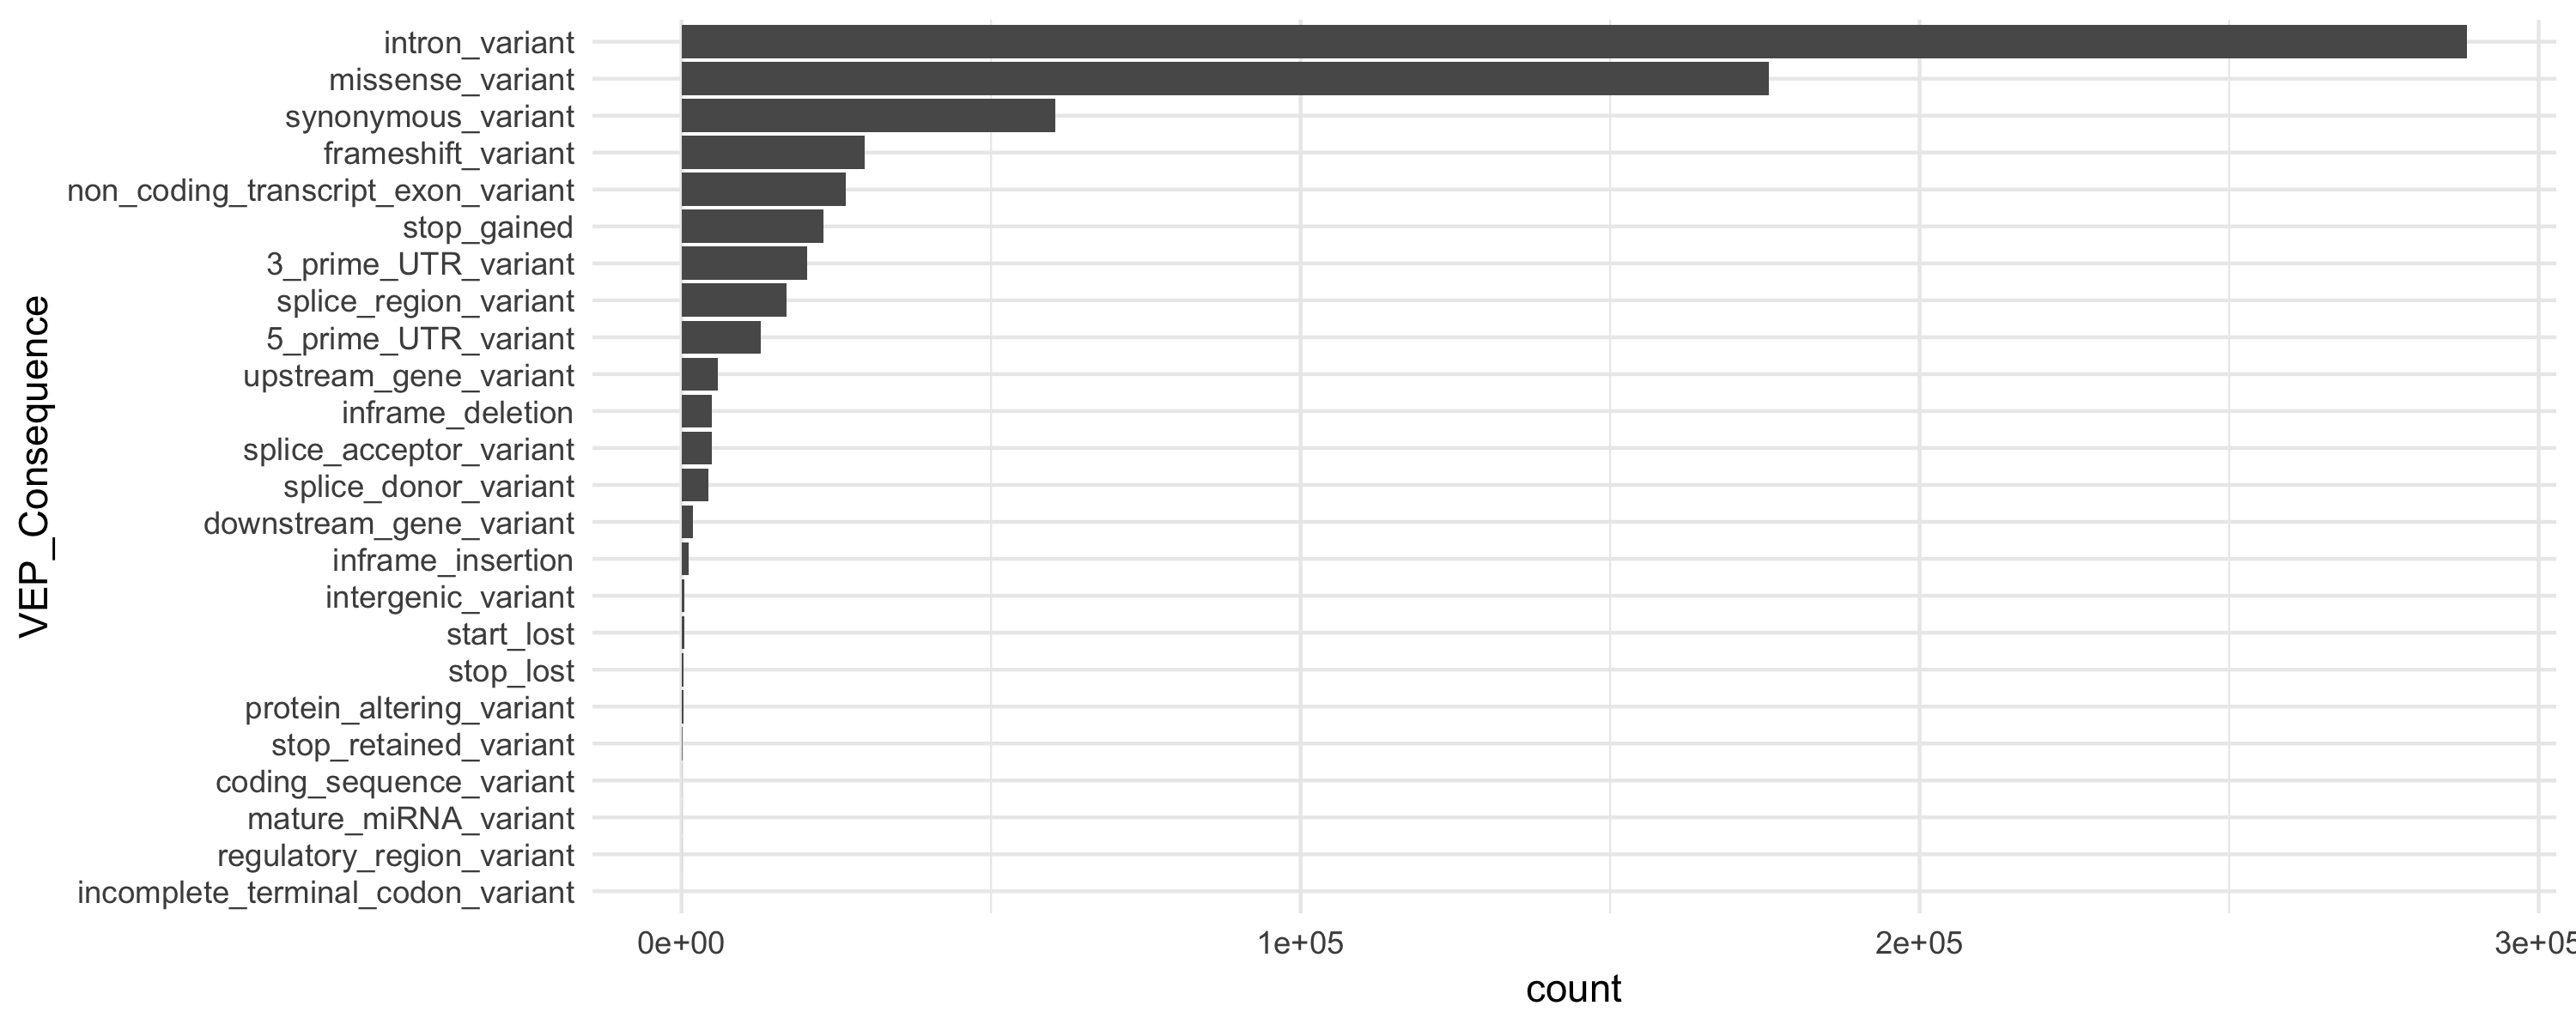

In [30]:
plot_histogram(impact, "VEP_Consequence", height = 4, flip = TRUE)

In [31]:
# [-434,123 rows] keep only the coding and splicing VEP_Consequence mutations
impact <- impact[impact$VEP_Consequence %in% c("missense_variant",
                                               "frameshift_variant",
                                               "stop_gained",
                                               "splice_acceptor_variant",
                                               "inframe_deletion",
                                               "splice_donor_variant",
                                               "inframe_insertion",
                                               "start_lost",
                                               "stop_lost"),]

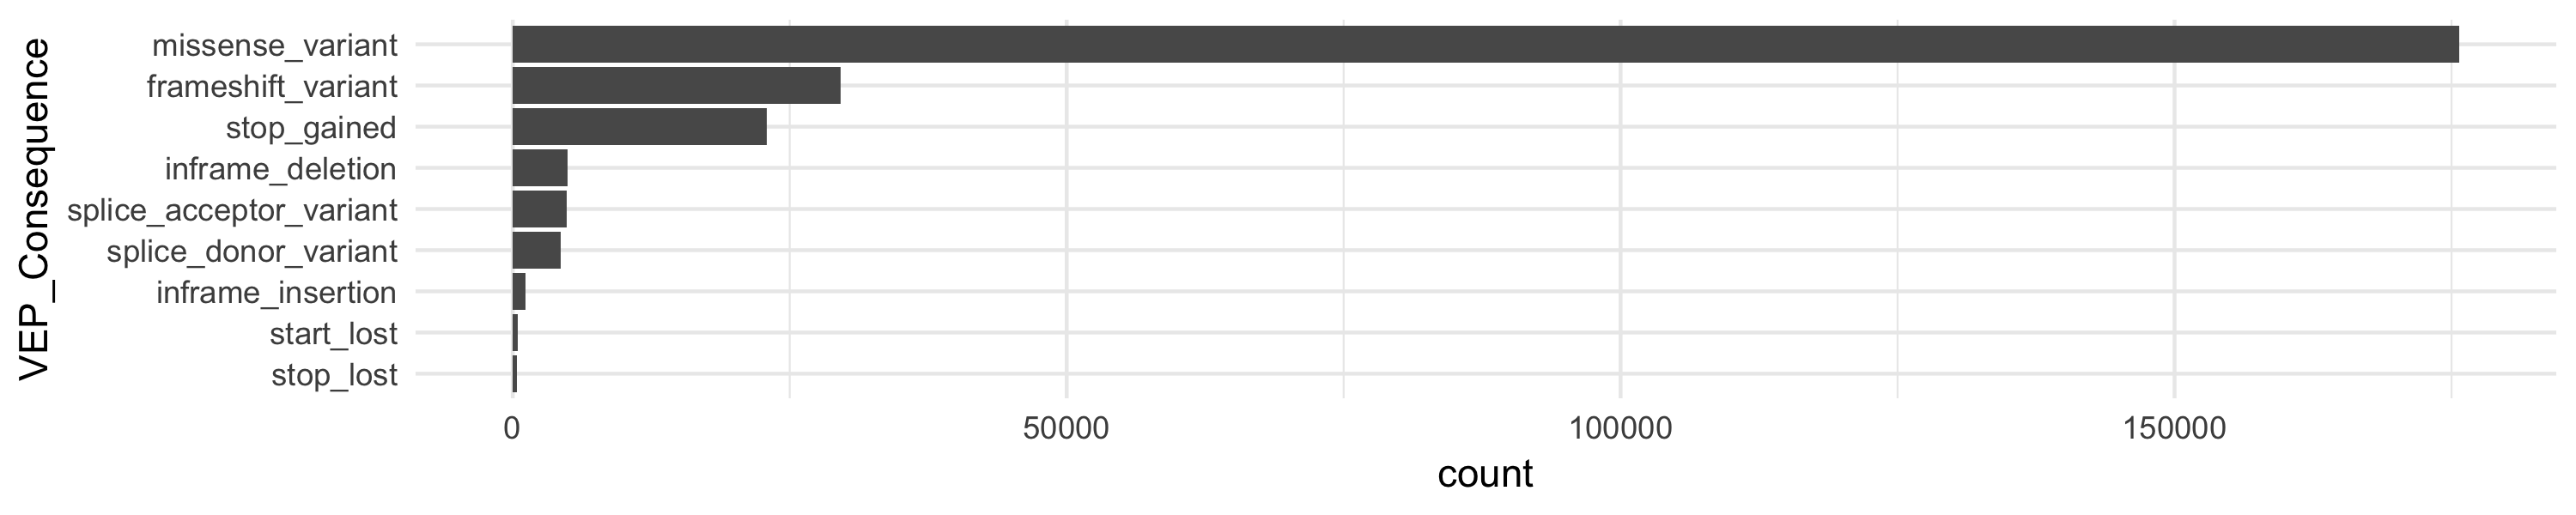

In [32]:
plot_histogram(impact, "VEP_Consequence", height = 2, flip = TRUE)

In [33]:
nrow(impact) # it was 588,547 before

[1] 244209

### [NEW - Remove] `match_status = Unmatched` or `match_status = Unknown`

In [34]:
get_table(impact$match_status)

values,count,freq
Matched,236657,96.9%
Unmatched,7550,3.1%
Unknown,2,0%
-- total --,244209,100%


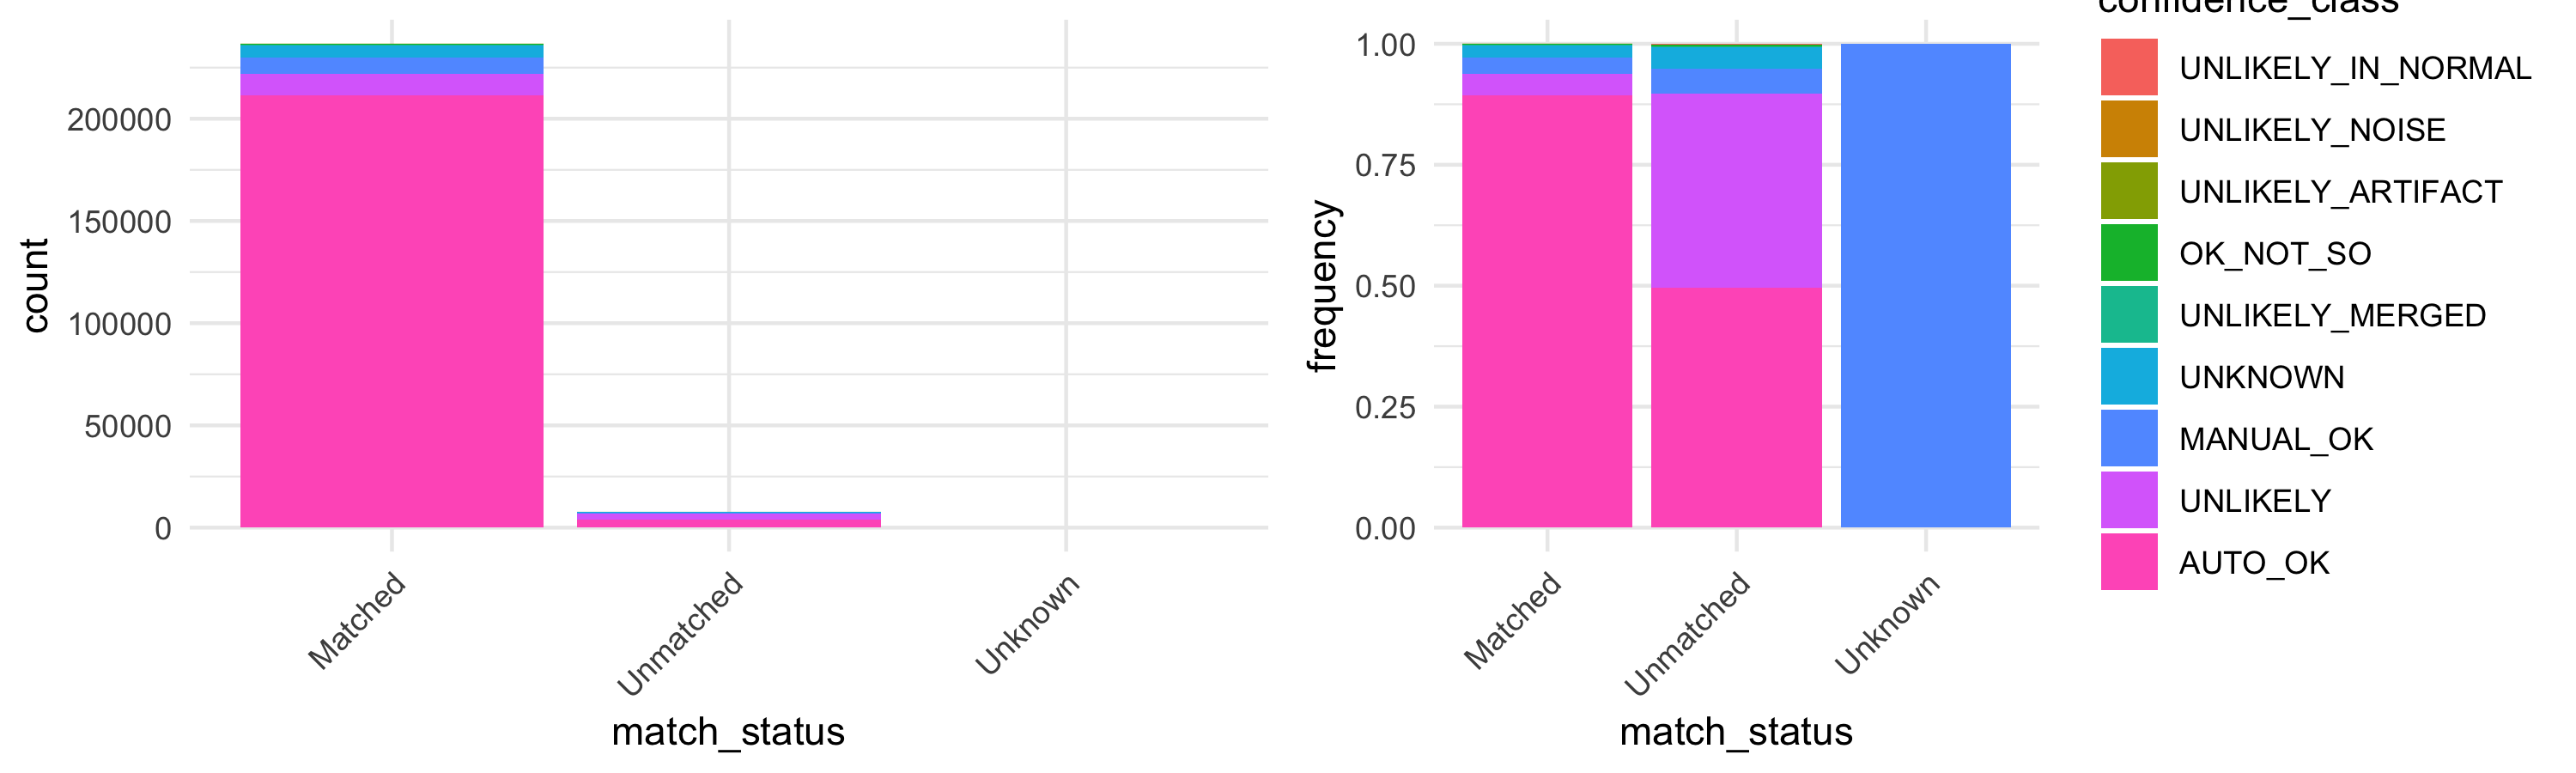

In [35]:
plot_contingency_table_as_histograms(impact, 'match_status', 'confidence_class')

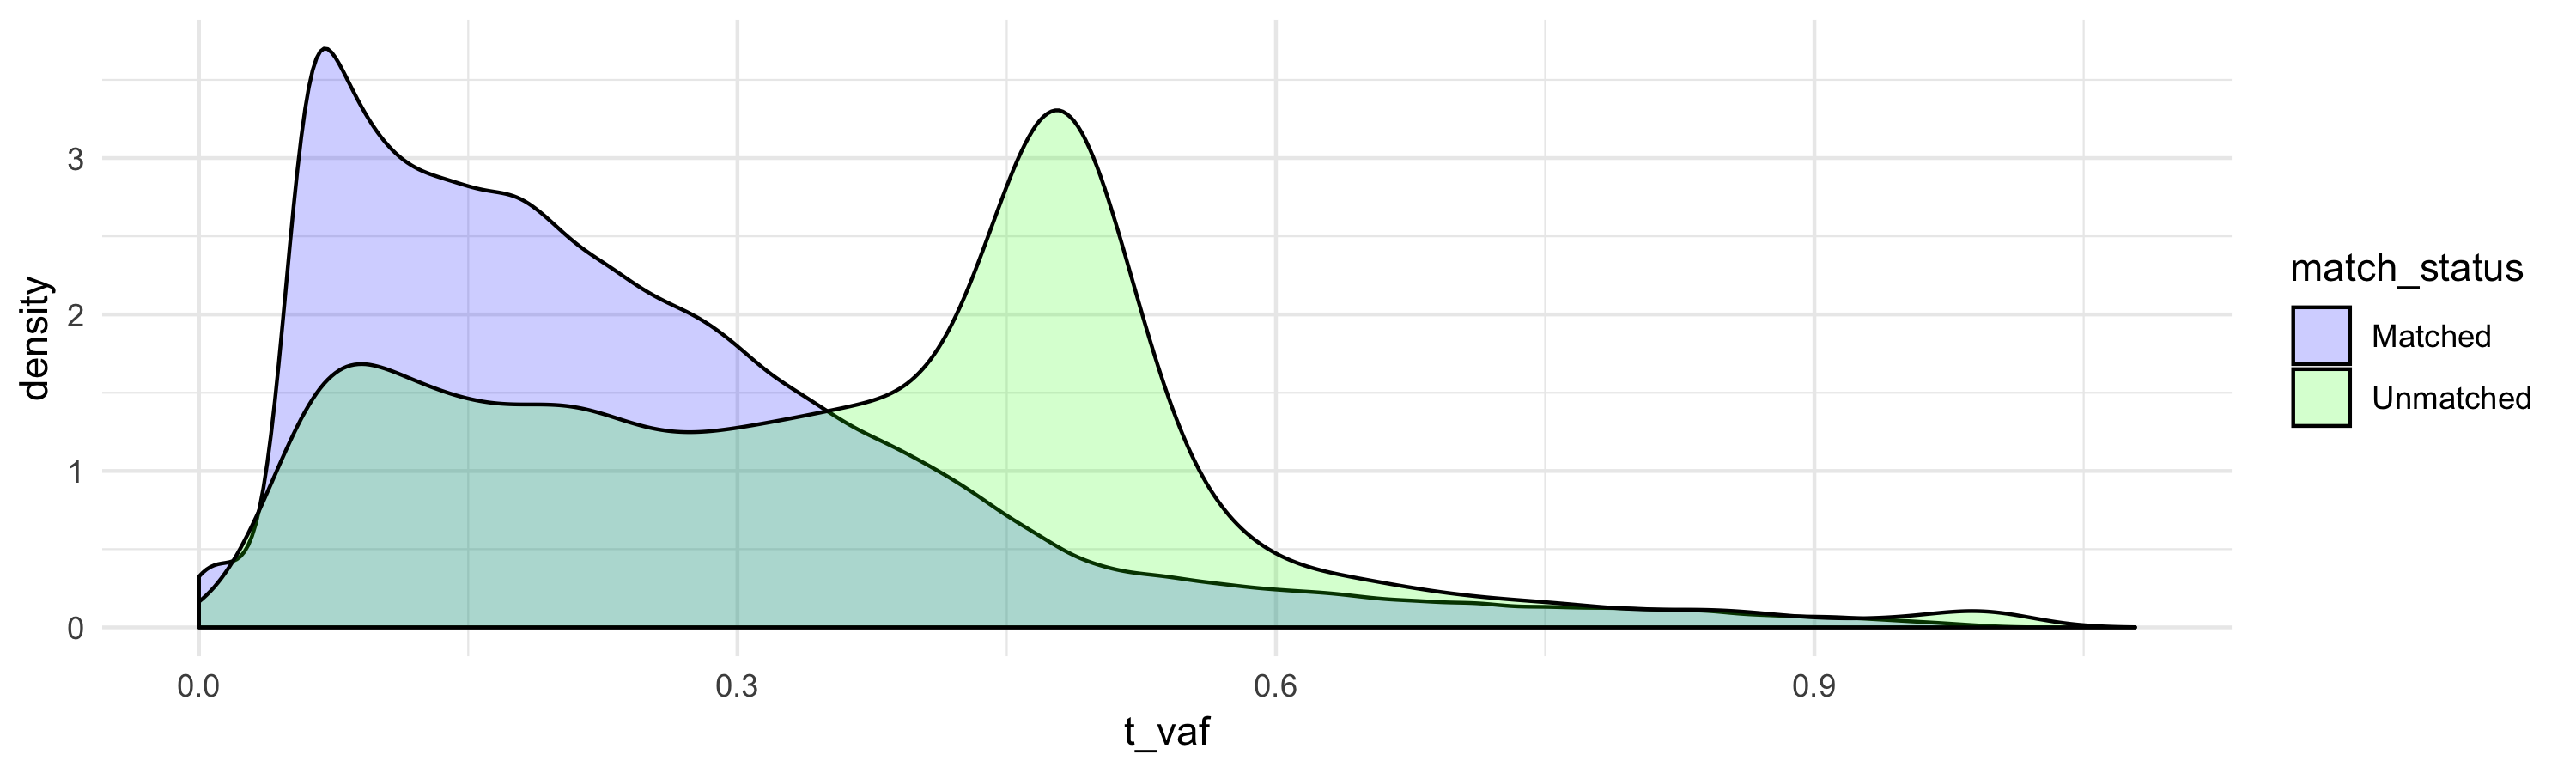

In [39]:
plot_density(impact[impact$match_status != "Unknown",], "t_vaf", "match_status")

In [34]:
# [-7,552 rows] remove rows having `match_status = Unmatched` or `match_status = Unknown`
impact <- impact[! impact$match_status %in% c("Unmatched", "Unknown"),]
# [-1 features] remove the `match_status` feature
impact$match_status <- NULL

### [NEW - Remove & Modify] `confidence_class`

In [35]:
get_table(impact$confidence_class)

values,count,freq
AUTO_OK,211377,89.3%
UNLIKELY,10551,4.5%
MANUAL_OK,8105,3.4%
UNKNOWN,5691,2.4%
UNLIKELY_MERGED,549,0.2%
OK_NOT_SO,291,0.1%
UNLIKELY_ARTIFACT,65,0%
UNLIKELY_NOISE,22,0%
UNLIKELY_IN_NORMAL,6,0%
-- total --,236657,100%


In [36]:
# [~642 rows] rename `confidence_class` ("UNLIKELY_MERGED", "UNLIKELY_ARTIFACT", "UNLIKELY_NOISE", "UNLIKELY_IN_NORMAL") to "UNLIKELY"
impact$confidence_class[impact$confidence_class %in% c("UNLIKELY_MERGED", "UNLIKELY_ARTIFACT", "UNLIKELY_NOISE", "UNLIKELY_IN_NORMAL")] <- "UNLIKELY"
get_table(impact$confidence_class)

values,count,freq
AUTO_OK,211377,89.3%
UNLIKELY,11193,4.7%
MANUAL_OK,8105,3.4%
UNKNOWN,5691,2.4%
OK_NOT_SO,291,0.1%
-- total --,236657,100%


In [37]:
get_table(impact$Consequence[impact$confidence_class == "UNKNOWN"])
get_table(impact$VEP_Consequence[impact$confidence_class == "UNKNOWN"])

values,count,freq
intronic,3056,53.7%
synonymous_SNV,1126,19.8%
exonic,1061,18.6%
UTR3,188,3.3%
UTR5,142,2.5%
upstream,54,0.9%
Unknown,34,0.6%
stoploss_SNV,10,0.2%
splicing_noncanonical,7,0.1%
downstream,5,0.1%


values,count,freq
missense_variant,4375,76.9%
frameshift_variant,467,8.2%
stop_gained,371,6.5%
splice_donor_variant,143,2.5%
splice_acceptor_variant,137,2.4%
stop_lost,78,1.4%
inframe_deletion,78,1.4%
start_lost,37,0.7%
inframe_insertion,5,0.1%
-- total --,5691,100%


In [38]:
# [-5,892 rows] remove rows having `confidence_class = UNKNOWN` or `confidence_class = OK_NOT_SO`
impact <- impact[! impact$confidence_class %in% c("UNKNOWN", "OK_NOT_SO"),]

### [Remove] `minor_contamination` > 0.01

In [39]:
print_count_and_proportion(nrow(impact[impact$minor_contamination > 0.01,]), nrow(impact))

[1] "0 over 230675 (0.00%)"

In [40]:
# [-0 rows] remove the contaminated rows minor_contamination > 0.01
impact <- impact[impact$minor_contamination <= 0.01,]
# [-1 feature] remove the minor_contamination feature
impact["minor_contamination"] <- NULL

### [Remove] `n_depth` < 20

In [41]:
nrow(impact[impact$n_depth < 20,])

[1] 372

In [42]:
# [-372 rows] remove rows having n_depth < 20
impact <- impact[impact$n_depth >= 20,]

### [Remove] `t_alt_plus_count` + `t_alt_neg_count` != `t_alt_count`

In [43]:
nrow(impact[impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count,])

[1] 38

In [44]:
# [-38 rows] remove the rows having t_alt_plus_count + t_alt_neg_count != t_alt_count
impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,]

### [Create] new features: `sample_mut_key`, `patient_key`

In [45]:
# [+1 feature] create a sample mutation key feature to idenfity unique rows
impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')

In [46]:
# [+1 feature] create a patient key feature to idenfity unique patient
impact$patient_key <- substr(impact$Tumor_Sample_Barcode, 1, 9)

### [Modify] `CDKN2Ap16INK4A` and `CDKN2Ap14ARF` reading frame

Two reading frame have been used for the gene `CDKN2A`:
* `CDKN2Ap16INK4A` is the "classic" reading frame for `CDKN2A`, the one used by OncoKB (see [OncoKB CDKN2A](http://oncokb.org/#/gene/CDKN2A))  
   → RefSeq. NM_000077.4  
   → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 1, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_000077.4)  
   → [Wikipedia article p16](https://en.wikipedia.org/wiki/P16)
* `CDKN2Ap14ARF` is an Alternative Reading Frame (ARF, as said in its name) for `CDKN2A`, not used by OncoKB  
  → RefSeq. NM_058195.3  
  → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 4, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_058195)  
  → [Wikipedia article p14arf](https://en.wikipedia.org/wiki/P14arf)
  
However, VEP thinks there's only one reading frame, the classic one `CDKN2A`. To correct this issue we:
* remove the mutations having the alternative reading frame and the classic reading frame in their tumor sample
* modify the `VEP_SYMBOL` of the mutations having the `CDKN2Ap14ARF` reading frame to `CDKN2Ap14ARF`

In [47]:
unique(impact$VEP_SYMBOL[impact$Hugo_Symbol %in% c("CDKN2Ap16INK4A", "CDKN2Ap14ARF")])

[1] "CDKN2A"

In [48]:
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap16INK4A",])

[1] 1470

In [49]:
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap14ARF",]) # mutations having the alternative reading data frame

dd <- impact %>% group_by(Tumor_Sample_Barcode) %>%
                 summarise(has_both_reading_frame = "CDKN2Ap14ARF" %in% Hugo_Symbol & "CDKN2Ap16INK4A" %in% Hugo_Symbol) %>%
                 filter(has_both_reading_frame)

# mutations having the alternative reading frame and the classic reading frame for this tumor sample
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap14ARF" &
            impact$Tumor_Sample_Barcode %in% dd$Tumor_Sample_Barcode,]) 

[1] 868

[1] 823

We delete from `impact` the rows that are `CDKN2Ap14ARF` and have already been read in the classic reading frame:

In [50]:
# [-823 rows] Hugo_Symbol = CDKN2Ap14ARF and CDKN2Ap16INK4A in the tumor sample
impact <- impact[! (impact$Hugo_Symbol == "CDKN2Ap14ARF" & impact$Tumor_Sample_Barcode %in% dd$Tumor_Sample_Barcode),]

### [Remove] the duplicated `sample_mut_key` rows

Some tumor sample have twice the same mutation, we keep the one with the minimal depth, and when the depth are equal the one with the minimum vaf.

In [51]:
impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
nrow(impact_redundant)

[1] 76

In [52]:
impact_redundant %>% group_by(sample_mut_key) %>% filter(n() > 3)

Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,sample_coverage,variant_caller_cv,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,sample_mut_key,patient_key


In [53]:
head(impact_redundant[order(impact_redundant$sample_mut_key),], 10)

Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,sample_coverage,variant_caller_cv,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_Existing_variation,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,sample_mut_key,patient_key
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,48,0.22917,11,103,0,0,15,22,5,6,0,UNLIKELY,1084,1,17_41234541_C_T,Sub,BRCA1,c.4237G>A,p.E1413K,non_synonymous_codon,missense_variant,BRCA1,ENST00000471181.2:c.4237G>A,ENSP00000418960.2:p.Glu1413Lys,E/K,SNV,12|24,NA,MODERATE,NA,tolerated(0.41),benign(0.138),CM123564,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_17_41234541_C_T,P-0000096
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,1061,0.27333,290,346,0,0,358,413,128,162,0,AUTO_OK,1084,5,17_41234541_C_T,Sub,BRCA1,c.4237G>A,p.E1413K,non_synonymous_codon,missense_variant,BRCA1,ENST00000471181.2:c.4237G>A,ENSP00000418960.2:p.Glu1413Lys,E/K,SNV,12|24,NA,MODERATE,NA,tolerated(0.41),benign(0.138),CM123564,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_17_41234541_C_T,P-0000096
JAK3,19,17942137,17942137,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.2878G>A,p.E960K,50,0.36000,18,90,0,0,16,16,6,12,0,UNLIKELY,1084,1,19_17942137_C_T,Sub,JAK3,c.2878G>A,p.E960K,non_synonymous_codon,missense_variant,JAK3,ENST00000458235.1:c.2878G>A,ENSP00000391676.1:p.Glu960Lys,E/K,SNV,21|24,NA,MODERATE,NA,deleterious(0),benign(0.372),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_17942137_C_T,P-0000096
JAK3,19,17942137,17942137,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.2878G>A,p.E960K,698,0.44842,313,331,0,0,163,221,125,188,0,AUTO_OK,1084,5,19_17942137_C_T,Sub,JAK3,c.2878G>A,p.E960K,non_synonymous_codon,missense_variant,JAK3,ENST00000458235.1:c.2878G>A,ENSP00000391676.1:p.Glu960Lys,E/K,SNV,21|24,NA,MODERATE,NA,deleterious(0),benign(0.372),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_17942137_C_T,P-0000096
PTPRS,19,5246019,5246019,nonsynonymous_SNV,SNP,C,G,P-0000096-T01-IM3,c.756G>C,p.M252I,70,0.14286,10,64,0,0,29,31,4,6,0,UNLIKELY,1084,1,19_5246019_C_G,Sub,PTPRS,c.756G>C,p.M252I,non_synonymous_codon,missense_variant,PTPRS,ENST00000357368.4:c.756G>C,ENSP00000349932.4:p.Met252Ile,M/I,SNV,10|38,NA,MODERATE,NA,tolerated(0.07),benign(0),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_5246019_C_G,P-0000096
PTPRS,19,5246019,5246019,nonsynonymous_SNV,SNP,C,G,P-0000096-T01-IM3,c.756G>C,p.M252I,563,0.18295,103,227,0,0,154,306,40,63,0,AUTO_OK,1084,5,19_5246019_C_G,Sub,PTPRS,c.756G>C,p.M252I,non_synonymous_codon,missense_variant,PTPRS,ENST00000357368.4:c.756G>C,ENSP00000349932.4:p.Met252Ile,M/I,SNV,10|38,NA,MODERATE,NA,tolerated(0.07),benign(0),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_5246019_C_G,P-0000096
RHOA,3,49412884,49412884,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.139G>A,p.E47K,58,0.39655,23,100,0,0,20,15,12,11,0,UNLIKELY,1084,1,3_49412884_C_T,Sub,RHOA,c.139G>A,p.E47K,non_synonymous_codon,missense_variant,RHOA,ENST00000418115.1:c.139G>A,ENSP00000400175.1:p.Glu47Lys,E/K,SNV,2|5,NA,MODERATE,NA,deleterious(0.04),possibly_da

In [54]:
impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>% filter(t_depth == min(t_depth)) %>% filter(t_vaf == min(t_vaf))
nrow(impact_redundant_to_delete)

[1] 38

In [55]:
# [-38 rows] duplicated mutation for the same sample_mut_key
impact <- impact[! (impact$sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                    impact$t_depth %in% impact_redundant_to_delete$t_depth &
                    impact$t_vaf %in% impact_redundant_to_delete$t_vaf),]

### [None] Remove hypermutated patients?

In [56]:
tumor_summary <- impact %>% group_by(Tumor_Sample_Barcode) %>% summarise(number_of_mutations = n())
head(tumor_summary)

Tumor_Sample_Barcode,number_of_mutations
None-T01-IM6,6
P-0000012-T02-IM3,1
P-0000012-T03-IM3,30
P-0000012-T04-IM6,9
P-0000023-T01-IM3,5
P-0000024-T01-IM3,6


In [57]:
nrow(tumor_summary)
summary(tumor_summary$number_of_mutations)
nrow(tumor_summary[tumor_summary$number_of_mutations >= 100,])

[1] 26143

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   5.000   8.775   8.000 619.000 

[1] 170

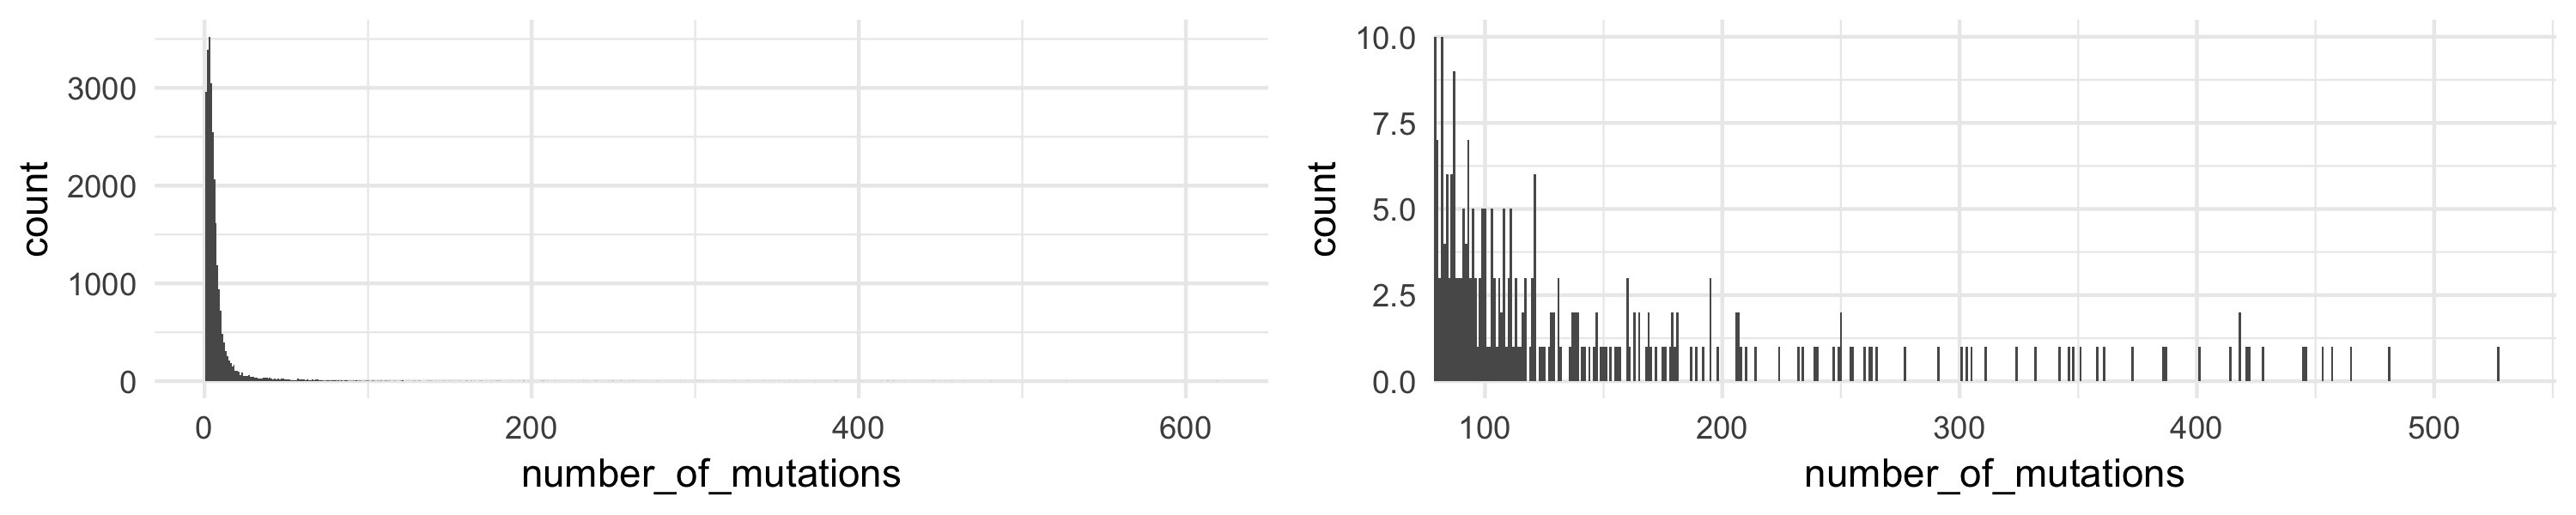

In [58]:
plot1 <- ggplot(tumor_summary) + geom_histogram(aes(number_of_mutations), binwidth = 1)
plot2 <- plot1 + coord_cartesian(xlim = c(100, 530), ylim = c(0, 10))
plot_side_by_side(plot1, plot2)

We decided not to remove any hypermutated patient.

### [Remove] DNP and TNP counted twice

Some `SNP` are overlapped by a `DNP` or a `TNP`, we find them and remove them.

In [59]:
overlapping_risk_dnp_or_tnp <- as.data.frame(impact %>% group_by(Tumor_Sample_Barcode, VEP_SYMBOL) %>%
                                             filter(n() > 1 &
                                                    "SNP" %in% Variant_Type &
                                                    ("DNP" %in% Variant_Type |
                                                     "TNP" %in% Variant_Type)))

nrow(overlapping_risk_dnp_or_tnp)

[1] 8031

In [60]:
find_overlapping_dnp_or_tnp <- function(data, tsb, chr, start) {
    result <- data %>% filter(Tumor_Sample_Barcode == tsb &
                              Chromosome == chr &
                              ((Variant_Type == "DNP" & (Start_Position == start | Start_Position == start - 1) |
                               (Variant_Type == "TNP" & (Start_Position == start | Start_Position == start - 1 | Start_Position == start - 2)))))

    if (nrow(result) == 0)
        return ("no")
    else
        return (toString(paste(nrow(result), result$Start_Position, result$Reference_Allele, result$Tumor_Seq_Allele2, result$t_vaf, result$confidence_class, sep = ' | ')))
}

In [61]:
overlapping_dnp_or_tnp <- overlapping_risk_dnp_or_tnp %>% filter(Variant_Type == "SNP") %>%
                                                          group_by(sample_mut_key) %>%
                                                          mutate(overlap = find_overlapping_dnp_or_tnp(overlapping_risk_dnp_or_tnp, Tumor_Sample_Barcode, Chromosome, Start_Position)) %>%
                                                          filter(overlap != "no") %>%
                                                          select(sample_mut_key, VEP_SYMBOL, Start_Position, Variant_Type, Reference_Allele, Tumor_Seq_Allele2, Tumor_Sample_Barcode, t_vaf, confidence_class, overlap)

nrow(overlapping_dnp_or_tnp)

[1] 3843

Most of them were classified as `UNLIKELY`:

In [62]:
get_table(overlapping_dnp_or_tnp$confidence_class)

values,count,freq
UNLIKELY,3738,97.3%
AUTO_OK,92,2.4%
MANUAL_OK,13,0.3%
-- total --,3843,100%


Except for a few, the `SNP` and the overlapping `DNP/TNP` have really close `t_vaf`:

In [63]:
overlapping_dnp_or_tnp$other_t_vaf <- sapply(overlapping_dnp_or_tnp$overlap, function(x) as.numeric(strsplit(x, ' \\| ')[[1]][5]))

In [64]:
nrow(overlapping_dnp_or_tnp)
get_table(abs(overlapping_dnp_or_tnp$t_vaf - overlapping_dnp_or_tnp$other_t_vaf) > 0.01)
get_table(abs(overlapping_dnp_or_tnp$t_vaf - overlapping_dnp_or_tnp$other_t_vaf) > 0.05)

[1] 3843

values,count,freq
FALSE,3766,98%
TRUE,77,2%
-- total --,3843,100%


values,count,freq
FALSE,3835,99.8%
TRUE,8,0.2%
-- total --,3843,100%


In [65]:
# [-3843 rows] SNV found as DNP or TNP
impact <- impact[! impact$sample_mut_key %in% overlapping_dnp_or_tnp$sample_mut_key,]

## Process raw features

### [Modify] deal with `NA` values

In [66]:
count_na <- function(data) {
    return (sum(is.na(data)))
}

In [67]:
replace_na <- function(data, feature_name, replace_value){
    data[is.na(data[,feature_name]), feature_name] <- replace_value
    
    return (data)
}

#### VAG

In [68]:
for (c in vag_colnames)
    print(sprintf("%17s: %d", c, count_na(impact[,c])))

[1] "           VAG_VT: 0"
[1] "         VAG_GENE: 149"
[1] "  VAG_cDNA_CHANGE: 219"
[1] "VAG_PROTEIN_CHANGE: 219"
[1] "       VAG_EFFECT: 149"


In [69]:
impact <- replace_na(impact, "VAG_GENE"          , "unknown")
impact <- replace_na(impact, "VAG_cDNA_CHANGE"   , "unknown")
impact <- replace_na(impact, "VAG_PROTEIN_CHANGE", "unknown")
impact <- replace_na(impact, "VAG_EFFECT"        , "unknown")

#### VEP

In [70]:
for (c in vep_colnames)
    print(sprintf("%17s: %d", c, count_na(impact[,c])))

[1] "  VEP_Consequence: 0"
[1] "       VEP_SYMBOL: 0"
[1] "        VEP_HGVSc: 6"
[1] "        VEP_HGVSp: 8413"
[1] "  VEP_Amino_acids: 8412"
[1] "VEP_VARIANT_CLASS: 0"
[1] "         VEP_EXON: 6863"
[1] "       VEP_INTRON: 217195"


In [71]:
impact[is.na(impact$VEP_HGVSc),]

Hugo_Symbol    Chromosome Start_Position End_Position
83434  CDKN2Ap16INK4A 9          21974658       21974895    
265256 MAPK3          16         30134458       30135078    
266479 SMAD3          15         67457371       67457373    
331315 MSH2           2          47630177       47630419    
384985 AURKB          17          8108003        8108479    
577965 HLA-B          6          31324218       31325240    
       Consequence            Variant_Type
83434  splicing               DEL         
265256 nonsynonymous_SNV      DEL         
266479 nonframeshift_deletion DEL         
331315 nonsynonymous_SNV      DEL         
384985 splicing               DEL         
577965 splicing               DEL         
       Reference_Allele                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
83434  CTGCAGACCCTCTACCCACCTGGATCGGCCTCCGACCGTAACTATTCGGTGCGTTGGGCAGCGCCCCCGCCTCCAGCAGCGCCCGCACCTCCTCTACCCGACCCCGGGCCGCGGCCGTGGCCAGCCAGTCAGCCGAAGGCTCCATGCTGCTCCCCGCCGCCGGCTCCATGCTGCTCCCCGCCGCCCGCTGCCTGCTCTCCCCCTCTCCGCAGCCGCCGAGCGCACGCGGTCCGCCCCA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
265256 GGACCCCCGGGCCGACCCCCTCGGTTCTACGGGGCTCCCCGCCCCCGCCCCCCTGAGCCGCCGCCGCCGCCATCTCCACTCCTCCCCTCCCACCGCCCTCCTCCCCACGGCGGCCCCGCCCGAGGCCCCGCCCCTTCCCGCCTGCCTGTCACCCGCAGGGCCGCGCGCGCCAGGCCCCGCCCTTGCCCCGGCCCCGCGTGGGCCTGGAGCTGTCACGTGACCCGCCCCGCGCGCGCCCGCCCTTCTTGCCCCAGGTTCGGGGGCCATGGGTCCCTGCGGGCTCCGCGGCCTCCAGGTCACCGGGAGGTTCGGCAGCGCCGCCTCGGAGACTGTCCTCACCCTCCCCTCGATGGCGAAGCGGCCAGGGCGTGACCTACCAGAGCCACCCAGCCAATGTATGCGGCAGCCCACCAGAACCTGGGCCCGGGATCACCCTAGGTTAAAAATAATGTTCTAATAAATGGATCAAATTTTACAGATGGAGAATCTGAGAGTTAGGTTTACTAACTTGGGTAAGGTCACTAGTAGTGACAGCTGAGACTCAAAATGGTGTCTTCTGACACAGAGACTCTTTCTAATTCCATGCCTCTCAGAGTCCTAGACTGTTTTTATTTTATTATA                                                                                                                                                                                                                                                                                                                                                                                                                  
266479 GAA                                                                                                                                                                                

8413 mutations have `VEP_HGVSp` = `NA`, almost all of them being splicing mutations:

In [72]:
get_table(impact$VEP_Consequence[is.na(impact$VEP_HGVSp)])

values,count,freq
splice_acceptor_variant,4348,51.7%
splice_donor_variant,3880,46.1%
frameshift_variant,90,1.1%
stop_lost,51,0.6%
start_lost,26,0.3%
inframe_insertion,7,0.1%
inframe_deletion,7,0.1%
stop_gained,4,0%
-- total --,8413,100%


8412 mutations have `VEP_Amino_acids` = `NA`, most of them being the one having `VEP_HGVSp = NA`:

In [73]:
count_na(impact$VEP_Amino_acids)
table(impact$mut_key[is.na(impact$VEP_Amino_acids)] %in% impact$mut_key[is.na(impact$VEP_HGVSp)])

[1] 8412


FALSE  TRUE 
  108  8304 

In [74]:
get_table(impact$VEP_Consequence[is.na(impact$VEP_Amino_acids) & ! is.na(impact$VEP_HGVSp)])

values,count,freq
splice_acceptor_variant,106,98.1%
start_lost,1,0.9%
frameshift_variant,1,0.9%
-- total --,108,100%


In [75]:
nrow(impact[impact$VEP_Consequence == "splice_acceptor_variant" & ! is.na(impact$VEP_HGVSp) & impact$VEP_HGVSp != "unknown",])
nrow(impact[impact$VEP_Consequence == "splice_donor_variant" & ! is.na(impact$VEP_HGVSp) & impact$VEP_HGVSp != "unknown",])

[1] 107

[1] 32

In [76]:
impact <- replace_na(impact, "VEP_HGVSc"      , "unknown")
impact <- replace_na(impact, "VEP_HGVSp"      , "unknown")
impact <- replace_na(impact, "VEP_Amino_acids", "unknown")

`VEP_EXON` and `VEP_INTRON` are complementary: when one is `NA` the other has a value, except for 41 cases.

In [77]:
get_table(is.na(impact$VEP_EXON) & is.na(impact$VEP_INTRON))

values,count,freq
FALSE,225521,100%
TRUE,40,0%
-- total --,225561,100%


#### VEP additional

In [78]:
for (c in vep_add_colnames)
    print(sprintf("%22s: %d", c, count_na(impact[,c])))

[1] "            VEP_IMPACT: 0"
[1] "          VEP_CLIN_SIG: 192133"
[1] "              VEP_SIFT: 65770"
[1] "          VEP_PolyPhen: 64816"
[1] "VEP_Existing_variation: 118709"
[1] "        VEP_COSMIC_CNT: 151448"


`NA` values might correspond to not found, we replace them by `"unknown"`:

In [79]:
impact <- replace_na(impact, "VEP_CLIN_SIG"          , "unknown")
impact <- replace_na(impact, "VEP_SIFT"              , "unknown")
impact <- replace_na(impact, "VEP_PolyPhen"          , "unknown")
impact <- replace_na(impact, "VEP_Existing_variation", "unknown")
impact <- replace_na(impact, "VEP_COSMIC_CNT"        , "unknown")

#### VEP gnomAD

In [80]:
for (c in vep_gnomad_colnames)
    print(sprintf("%27s: %d", c, count_na(impact[,c])))

[1] "              VEP_gnomAD_AF: 181934"
[1] "VEP_gnomAD_genome_AC.AN_AFR: 211323"
[1] "VEP_gnomAD_genome_AC.AN_AMR: 211323"
[1] "VEP_gnomAD_genome_AC.AN_ASJ: 211323"
[1] "VEP_gnomAD_genome_AC.AN_EAS: 211323"
[1] "VEP_gnomAD_genome_AC.AN_FIN: 211323"
[1] "VEP_gnomAD_genome_AC.AN_NFE: 211323"
[1] "VEP_gnomAD_genome_AC.AN_OTH: 211323"
[1] " VEP_gnomAD_exome_AC.AN_AFR: 170539"
[1] " VEP_gnomAD_exome_AC.AN_AMR: 170539"
[1] " VEP_gnomAD_exome_AC.AN_ASJ: 170539"
[1] " VEP_gnomAD_exome_AC.AN_EAS: 170539"
[1] " VEP_gnomAD_exome_AC.AN_FIN: 170539"
[1] " VEP_gnomAD_exome_AC.AN_NFE: 170539"
[1] " VEP_gnomAD_exome_AC.AN_OTH: 170539"


`NA` values might correspond to not found, we replace them by a null allele value, or by `0 | 0` for the Allele count | Total number of alleles:

In [81]:
impact <- replace_na(impact, "VEP_gnomAD_AF", 0.0)

for (c in vep_gnomad_colnames[grepl("_AC.AN_", vep_gnomad_colnames)])
    impact <- replace_na(impact, c, " 0 | 0")

### [Modify] `occurence_in_normals` -> `frequency_in_normals`

In [82]:
dd <- head(unique(impact$occurence_in_normals), 10)
dd[dd == '0'] <- "0;0"
dd <- data.frame(dd, sapply(dd, function(s) as.double(strsplit(s, split = ';')[[1]][2])), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
0;0,0.000
0;0,0.000
1;0.026,0.026
6;0.158,0.158
3;0.079,0.079
4;0.105,0.105
7;0.184,0.184
2;0.051,0.051
3;0.077,0.077
7;0.179,0.179


174 values with different notation, we will correct it:

In [87]:
nrow(impact[impact$occurence_in_normals != '0' & !grepl(';', impact$occurence_in_normals),])

[1] 174

In [88]:
# [~ every rows] occurence_in_normals -> frequency_in_normals
impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
impact$occurence_in_normals[!grepl(';', impact$occurence_in_normals)] <- paste('0;', impact$occurence_in_normals[!grepl(';', impact$occurence_in_normals)])
impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                      function(s) as.double(strsplit(s, split = ';')[[1]][2]))
impact$occurence_in_normals <- NULL

### [Modify] `VEP_HGVSc`

In [213]:
dd <- head(impact$VEP_HGVSc, 10)
dd <- data.frame(dd, sapply(dd, function(x) strsplit(x, ':')[[1]][2]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
ENST00000269305.4:c.766A>C,c.766A>C
ENST00000262741.5:c.894C>G,c.894C>G
ENST00000350721.4:c.7292G>T,c.7292G>T
ENST00000257290.5:c.1393T>A,c.1393T>A
ENST00000281708.4:c.1237-1G>T,c.1237-1G>T
ENST00000281708.4:c.181G>T,c.181G>T
ENST00000264932.6:c.1444C>T,c.1444C>T
ENST00000399503.3:c.904G>T,c.904G>T
ENST00000399503.3:c.2087+2T>G,c.2087+2T>G
ENST00000439151.2:c.5338G>T,c.5338G>T


In [214]:
# [~ every rows] VEP_HGVSc -> readable VEP_HGVSc
impact$VEP_HGVSc <- sapply(impact$VEP_HGVSc, function(x) strsplit(x, ':')[[1]][2])
impact <- replace_na(impact, "VEP_HGVSc", "unknown") # 5 NA values that we need to handle

### [Modify] `VEP_HGVSp`

In [215]:
get_HGVSp_from_vep <- function(HGVSp_string) {
    
    if (HGVSp_string == "unknown")
        return ("unknown")
    
    HGVSp_string <- strsplit(HGVSp_string, ':')[[1]][2]
    
    protein_long_name <- c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Glu', 'Gln', 'Gly', 'His', 'Ile', 'Leu', 'Lys',
                           'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
    protein_short_name <- c('A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K',
                            'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    for (name in protein_long_name)
        HGVSp_string <- gsub(name, protein_short_name[match(name, protein_long_name)], HGVSp_string)
    
    HGVSp_string <- gsub('Ter', '*', HGVSp_string)
    HGVSp_string <- gsub('%3D', '=', HGVSp_string)
    
    return (HGVSp_string)
}

In [216]:
dd <- head(impact$VEP_HGVSp, 10)
dd <- data.frame(dd, sapply(dd, get_HGVSp_from_vep), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
ENSP00000269305.4:p.Thr256Pro,p.T256P
ENSP00000262741.5:p.Ile298Met,p.I298M
ENSP00000343741.4:p.Arg2431Met,p.R2431M
ENSP00000257290.5:p.Leu465Met,p.L465M
unknown,unknown
ENSP00000281708.3:p.Gly61Ter,p.G61*
ENSP00000264932.6:p.Pro482Ser,p.P482S
ENSP00000382423.3:p.Glu302Ter,p.E302*
unknown,unknown
ENSP00000395929.2:p.Val1780Phe,p.V1780F


In [217]:
# [~ every rows] VEP_HGVSp -> readable VEP_HGVSp
impact$VEP_HGVSp <- sapply(impact$VEP_HGVSp, get_HGVSp_from_vep)

### [Modify] `VEP_SIFT`

In [218]:
dd <- head(unique(impact$VEP_SIFT), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old,new1,new2
deleterious(0),deleterious,0.00
deleterious(0.01),deleterious,0.01
unknown,unknown,NA
tolerated_low_confidence(0.12),tolerated_low_confidence,0.12
tolerated(0.4),tolerated,0.40
tolerated(0.17),tolerated,0.17
deleterious(0.02),deleterious,0.02
deleterious_low_confidence(0),deleterious_low_confidence,0.00
tolerated_low_confidence(0.1),tolerated_low_confidence,0.10
tolerated(0.08),tolerated,0.08


In [219]:
# [~ every rows] VEP_SIFT -> VEP_SIFT_class & VEP_SIFT_score
impact$VEP_SIFT_class <- sapply(impact$VEP_SIFT, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_SIFT_score <- sapply(impact$VEP_SIFT, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_SIFT <- NULL

Warning, there is `NA` values in `VEP_SIFT_score` for `unknown`.

### [Modify] `VEP_PolyPhen`

In [220]:
dd <- head(unique(impact$VEP_PolyPhen), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old,new1,new2
probably_damaging(0.999),probably_damaging,0.999
benign(0.277),benign,0.277
probably_damaging(0.997),probably_damaging,0.997
probably_damaging(0.965),probably_damaging,0.965
unknown,unknown,NA
benign(0.005),benign,0.005
probably_damaging(0.952),probably_damaging,0.952
possibly_damaging(0.738),possibly_damaging,0.738
probably_damaging(0.995),probably_damaging,0.995
possibly_damaging(0.472),possibly_damaging,0.472


In [221]:
# [~ every rows] VEP_PolyPhen -> VEP_PolyPhen_class & VEP_PolyPhen_score
impact$VEP_PolyPhen_class <- sapply(impact$VEP_PolyPhen, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_PolyPhen_score <- sapply(impact$VEP_PolyPhen, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_PolyPhen <- NULL

Warning, there is `NA` values in `VEP_PolyPhen_score` for `unknown`.

### [Modify] `VEP_Existing_variation` -> `VEP_in_dbSNP`

A mutation has the feature`VEP_in_dbSNP = TRUE` when we found a dnSNP id in the `VEP_Existing_variation` column.

In [222]:
dd <- head(unique(impact$VEP_Existing_variation), 10)
dd <- data.frame(dd, grepl("rs", dd), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
CM102355&CD120857&TP53_g.13403A>C&COSM44544&COSM44662&COSM45526&COSM45830,FALSE
unknown,FALSE
rs759327414&COSM1039347,TRUE
rs775630094&COSM3782296&COSM3782297&COSM3782298&COSM3782299&COSM3782300&COSM3782301,TRUE
COSM5570654&COSM5570655&COSM5570656,FALSE
COSM3693022&COSM4784258,FALSE
COSM1589625&COSM990757,FALSE
COSM5586358&COSM5586359,FALSE
COSM4599799,FALSE
COSM44939&COSM46097,FALSE


In [223]:
# [~ every rows] VEP_Existing_variation -> VEP_in_dbSNP
impact$VEP_in_dbSNP <- grepl("rs", impact$VEP_Existing_variation)
impact$VEP_Existing_variation <- NULL

In [224]:
get_table(impact$VEP_in_dbSNP)

values,count,freq
FALSE,162754,72.2%
TRUE,62807,27.8%
-- total --,225561,100%


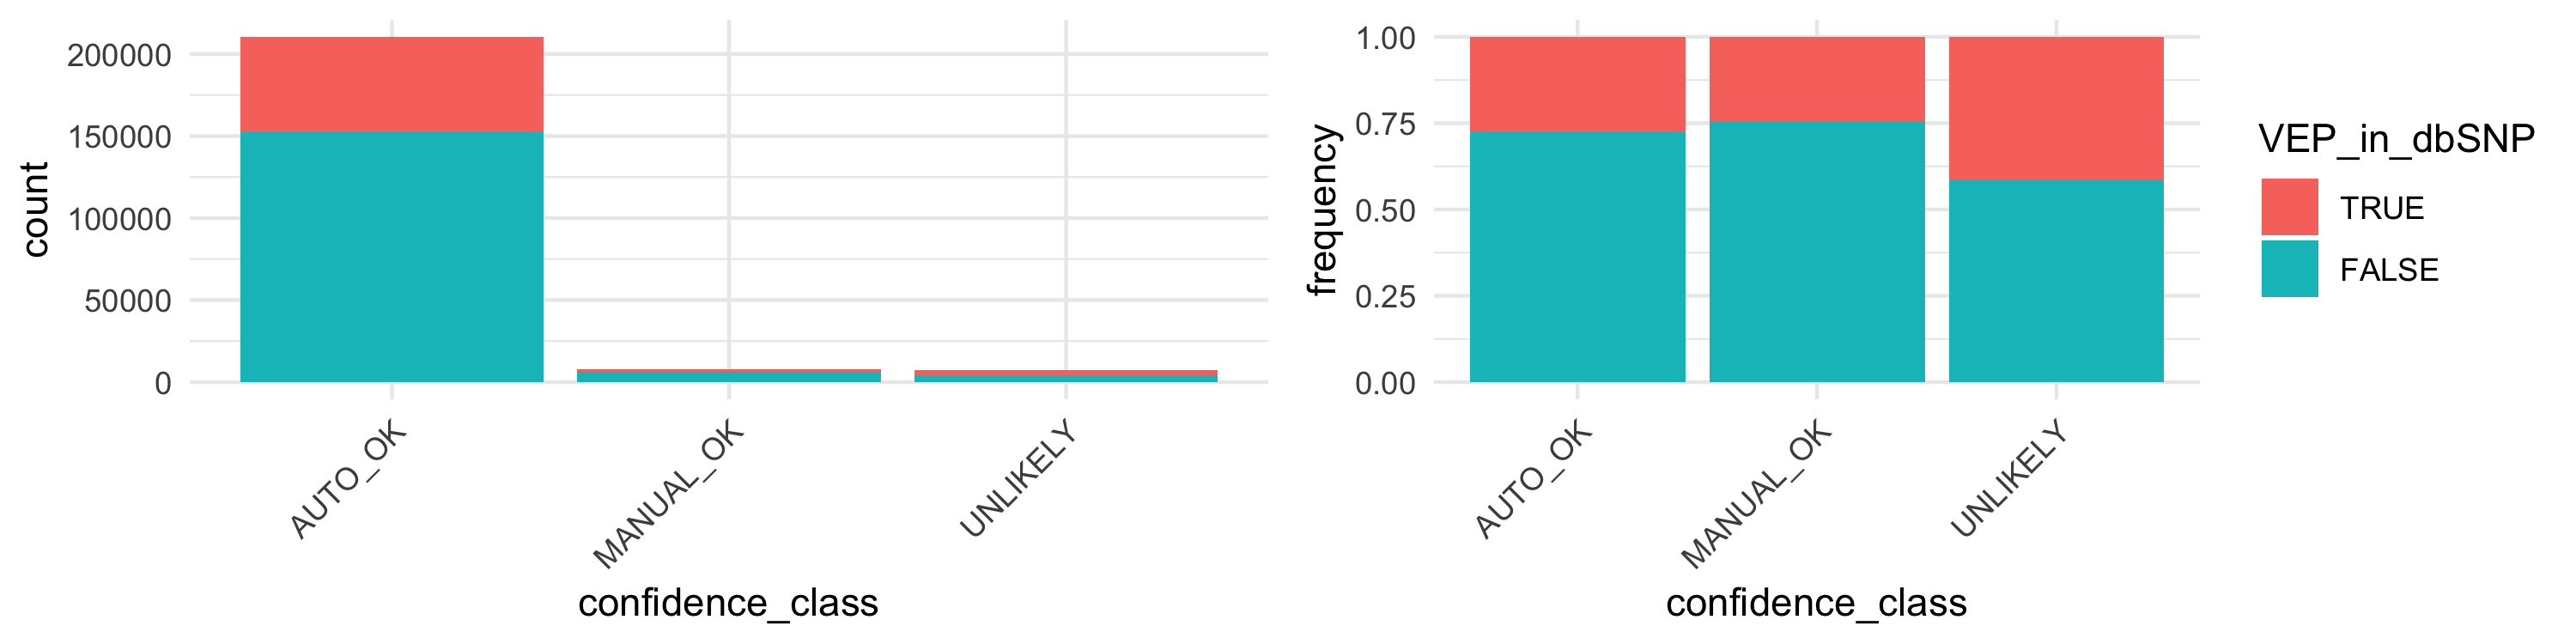

In [225]:
plot_contingency_table_as_histograms(impact, "confidence_class", "VEP_in_dbSNP", height = 2.5)

We clearly see the germline `t_vaf` for the `UNLIKELY` class.

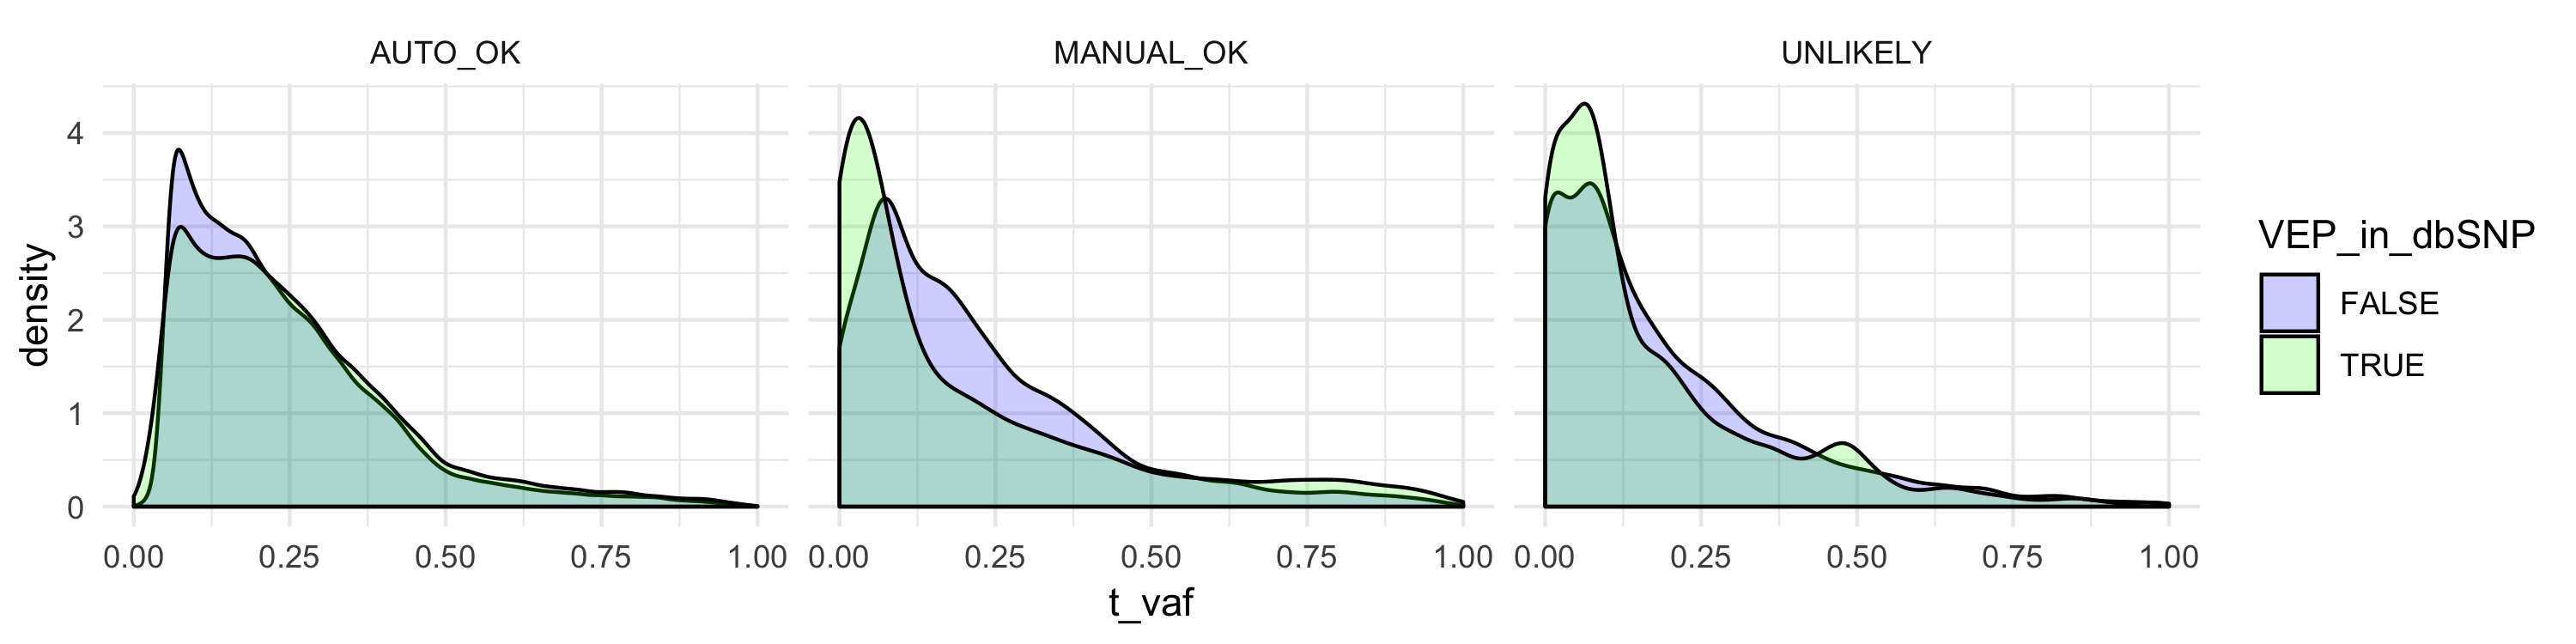

In [226]:
plot_density(impact, "t_vaf", fill = "VEP_in_dbSNP", height = 2.5) + facet_grid(col = vars(confidence_class))

### [Modify] `VEP_COSMIC_CNT`

In [227]:
get_cosmic_count_from_vep <- function(cosmic_count_string) {
    if (cosmic_count_string == "unknown")
        return (0)
    else
        return (sum(as.numeric(strsplit(cosmic_count_string, '&')[[1]])))
}

dd <- head(unique(impact$VEP_COSMIC_CNT), 10)
dd <- data.frame(dd, sapply(dd, get_cosmic_count_from_vep), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
1,1
unknown,0
1&1&1&1&1&1,6
1&1&1,3
1&1,2
53,53
158,158
19&21&14,54
229&230&200&230&179&789,1857
42&170,212


In [228]:
# [~ every rows] VEP_COSMIC_CNT -> readable VEP_COSMIC_CNT
impact$VEP_COSMIC_CNT <- sapply(impact$VEP_COSMIC_CNT, get_cosmic_count_from_vep)

### [Modify] VEP_CLIN_SIG

In [229]:
get_table(impact$VEP_CLIN_SIG) %>% filter(count >= 200)

values,count,freq
unknown,192133,85.2%
likely_pathogenic&pathogenic,9707,4.3%
not_provided&likely_pathogenic&pathogenic,5707,2.5%
pathogenic,4216,1.9%
likely_pathogenic,3790,1.7%
uncertain_significance,3577,1.6%
uncertain_significance&likely_pathogenic,983,0.4%
uncertain_significance&pathogenic,734,0.3%
likely_pathogenic&pathogenic&drug_response,679,0.3%
uncertain_significance&likely_pathogenic&pathogenic,630,0.3%


We group the values with the following rules:
* We consider 3 big different classes:
    * `pathogenic`: `pathogenic`, `likely_pathogenic`, `drug_response`, `risk_factor`
    * `benign`: `benign`, `likely_benign`
    * `unknown`: `NA` (has been previously replaced by `unknown`), `not_provided`, `uncertain_significance`
* A mutation having both `pathogenic` and `benign` classes is classified as `unknown`
* A mutation having a strong class (`pathogenic` or `benign`) and `unknown` class is classified as the strong class

In [230]:
get_simplified_clin_sig <- function(clin_sig_string) {
    if (clin_sig_string == "unknown")
        return ("unknown")
    else {
        tags <- unique(strsplit(clin_sig_string, '&')[[1]])
        
        tags <- gsub('likely_pathogenic', 'pathogenic', tags)
        tags <- gsub('drug_response'    , 'pathogenic', tags)
        tags <- gsub('risk_factor'      , 'pathogenic', tags)
        tags <- gsub('likely_benign'    , 'benign'    , tags)
        
        tags <- unique(tags)
        
        tags <- tags[! tags %in% c("not_provided", "uncertain_significance", "other")]
        
        if (length(tags) == 0 || length(tags) > 1)
            return ("unknown")
        else
            return (tags)
    }
}

In [231]:
dd <- head(unique(impact$VEP_CLIN_SIG), 20)
dd <- data.frame(dd, sapply(dd, get_simplified_clin_sig), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
unknown,unknown
likely_pathogenic&pathogenic,pathogenic
uncertain_significance&pathogenic,pathogenic
likely_pathogenic,pathogenic
not_provided&likely_pathogenic&pathogenic,pathogenic
pathogenic,pathogenic
uncertain_significance&likely_pathogenic,pathogenic
not_provided,unknown
uncertain_significance,unknown
uncertain_significance&likely_pathogenic&pathogenic,pathogenic


In [232]:
# [~ every rows] VEP_CLIN_SIG -> readable VEP_CLIN_SIG
impact$VEP_CLIN_SIG <- sapply(impact$VEP_CLIN_SIG, get_simplified_clin_sig)

In [233]:
get_table(impact$VEP_CLIN_SIG)

values,count,freq
unknown,196789,87.2%
pathogenic,27972,12.4%
benign,800,0.4%
-- total --,225561,100%


### [Modify & Create & Remove] vep_gnomad_colnames

In [234]:
pop_names <- c('AFR', 'AMR', 'ASJ', 'EAS', 'FIN', 'NFE', 'OTH')

#### `genome_AC.AN_<POP>` & `exome_AC.AN_<POP>` -> `total_AC.AN_<POP>`

For each population, we sum the allele count (`AC`) and total allele number (`AN`) on the exomes and the genomes. This operation creates 7 new features named `VEP_gnomAD_total_AC.AN_<POP>`.

In [235]:
get_gnomAD_total_AC.AN_pop <- function(data, pop_name) {
    genome_AC = as.integer(strsplit(data[paste0("VEP_gnomAD_genome_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    genome_AN = as.integer(strsplit(data[paste0("VEP_gnomAD_genome_AC.AN_", pop_name)], ' \\| ')[[1]][2])

    exome_AC = as.integer(strsplit(data[paste0("VEP_gnomAD_exome_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    exome_AN = as.integer(strsplit(data[paste0("VEP_gnomAD_exome_AC.AN_", pop_name)], ' \\| ')[[1]][2])
    
    return (paste(genome_AC + exome_AC, genome_AN + exome_AN, sep = ' | '))
}

In [236]:
dd <- tail(unique(impact[, c("VEP_gnomAD_genome_AC.AN_AFR", "VEP_gnomAD_exome_AC.AN_AFR")]), 10)
dd <- data.frame(dd, apply(dd, 1, function(x) get_gnomAD_total_AC.AN_pop(x, "AFR")), row.names = NULL)
colnames(dd) <- c("genome_AC.AN_AFR", "exome_AC.AN_AFR", "new (total_AC.AN_AFR)")
dd

genome_AC.AN_AFR,exome_AC.AN_AFR,new (total_AC.AN_AFR)
0 | 8140,0 | 15022,0 | 23162
5 | 8686,2 | 15304,7 | 23990
1 | 8730,0 | 15014,1 | 23744
0 | 0,1 | 13232,1 | 13232
5 | 8608,3 | 7828,8 | 16436
0 | 0,1 | 1970,1 | 1970
1 | 8702,1 | 15302,2 | 24004
3 | 8600,1 | 15014,4 | 23614
0 | 5927,0 | 12245,0 | 18172
1 | 8706,1 | 15276,2 | 23982


In [237]:
# [+7 features] VEP_gnomAD_total_AC.AN_<POP> (temporary feature)
for (pop in pop_names)
    impact[, paste0("VEP_gnomAD_total_AC.AN_", pop)] <- apply(impact, 1, function(x) get_gnomAD_total_AC.AN_pop(x, pop))

#### `total_AC.AN_<POP>` -> `total_AF_<POP>`

Foe each population, we convert `VEP_gnomAD_total_AC.AN_<POP>` to the corresponding allele frequency (`AF`), the allele frequency of the mutation in gnomAD exomes and genomes united. This operation creates 7 new features named `VEP_gnomAD_total_AF_<POP>`.

In [238]:
get_gnomAD_total_AF_pop <- function(data, pop_name) {
        
    AC = as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    AN = as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop_name)], ' \\| ')[[1]][2])
    
    if (AN == 0)
        return (0)
    else
        return (AC / AN)
}

In [239]:
dd <- tail(unique(impact[, c("VEP_gnomAD_total_AC.AN_AFR",
                             "VEP_gnomAD_total_AC.AN_AMR")]), 10)
dd <- data.frame(dd, apply(dd, 1, function(x) get_gnomAD_total_AF_pop(x, "AFR")),
                     apply(dd, 1, function(x) get_gnomAD_total_AF_pop(x, "AMR")), row.names = NULL)
colnames(dd) <- c("total_AC.AN_AFR", "total_AC.AN_AMR", "new1 (total_AF_AFR)", "new2 (total_AF_AMR)")
dd

total_AC.AN_AFR,total_AC.AN_AMR,new1 (total_AF_AFR),new2 (total_AF_AMR)
2 | 15304,3 | 33574,1.306848e-04,8.935486e-05
1 | 1970,0 | 17164,5.076142e-04,0.000000e+00
0 | 15068,2 | 33448,0.000000e+00,5.979431e-05
2 | 24004,0 | 34412,8.331945e-05,0.000000e+00
4 | 23614,5 | 34304,1.693910e-04,1.457556e-04
0 | 15172,1 | 32482,0.000000e+00,3.078628e-05
0 | 18172,0 | 27197,0.000000e+00,0.000000e+00
1 | 24018,0 | 34308,4.163544e-05,0.000000e+00
2 | 23982,0 | 34268,8.339588e-05,0.000000e+00
0 | 14040,0 | 32410,0.000000e+00,0.000000e+00


In [240]:
# [+7 features] VEP_gnomAD_total_AF_<POP>
for (pop in pop_names)
    impact[, paste0("VEP_gnomAD_total_AF_", pop)] <- apply(impact, 1, function(x) get_gnomAD_total_AF_pop(x, pop))

#### `total_AC.AN_<POP>` -> `VEP_gnomAD_total_AF_max`

We calculate the maximal `AF` among all 7 populations, for gnomAD exomes and genomes united. This operation creates 1 new feature named `VEP_gnomAD_total_AF_max`.

In [241]:
dd <- tail(unique(impact[, c("VEP_gnomAD_total_AF_AFR",
                             "VEP_gnomAD_total_AF_AMR")]), 10)

total_AF_columns <- colnames(dd)[grepl("VEP_gnomAD_total_AF_", colnames(dd))]

dd <- data.frame(dd, apply(dd, 1, function(x) max(as.numeric(x[total_AF_columns]))), row.names = NULL)
colnames(dd) <- c("total_AF_AFR", "total_AF_AMR", "new")
dd

total_AF_AFR,total_AF_AMR,new
3.415884e-04,5.409792e-05,3.415884e-04
2.917882e-04,1.452813e-04,2.917882e-04
4.211590e-05,0.000000e+00,4.211590e-05
7.557437e-05,3.123438e-05,7.557437e-05
4.867364e-04,8.052178e-05,4.867364e-04
1.306848e-04,8.935486e-05,1.306848e-04
5.076142e-04,0.000000e+00,5.076142e-04
0.000000e+00,5.979431e-05,5.979431e-05
1.693910e-04,1.457556e-04,1.693910e-04
0.000000e+00,3.078628e-05,3.078628e-05


In [242]:
# [+1 feature] VEP_gnomAD_total_AF_max
total_AF_columns <- colnames(impact)[grepl("VEP_gnomAD_total_AF_", colnames(impact))]
impact$VEP_gnomAD_total_AF_max <- apply(impact, 1, function(x) max(as.numeric(x[total_AF_columns])))

#### `total_AC.AN_<POP>` -> `VEP_gnomAD_total_AF`

We calculate the `AF` among all 7 populations, for gnomAD exomes and genomes united. This operation creates 1 new feature named `VEP_gnomAD_total_AF`.

In [243]:
get_gnomAD_total_AF <- function(data) {
    
    AC <- c()
    AN <- c()
    
    for (pop in pop_names) {
        AC <- c(AC, as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop)], ' \\| ')[[1]][1]))
        AN <- c(AN, as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop)], ' \\| ')[[1]][2]))
    }
                
    if (sum(AN) == 0)
        return (0)
    else
        return (sum(AC) / sum(AN))
}

In [244]:
total_AC.AN_columns <- colnames(impact)[grepl("VEP_gnomAD_total_AC.AN_", colnames(impact))]

dd <- tail(unique(impact[, total_AC.AN_columns]), 10)
dd <- data.frame(dd, apply(dd, 1, get_gnomAD_total_AF), row.names = NULL)
colnames(dd) <- c(total_AC.AN_columns, "new")
dd

VEP_gnomAD_total_AC.AN_AFR,VEP_gnomAD_total_AC.AN_AMR,VEP_gnomAD_total_AC.AN_ASJ,VEP_gnomAD_total_AC.AN_EAS,VEP_gnomAD_total_AC.AN_FIN,VEP_gnomAD_total_AC.AN_NFE,VEP_gnomAD_total_AC.AN_OTH,new
4 | 23614,5 | 34304,1 | 10074,1 | 18780,0 | 24686,3 | 123054,0 | 6380,5.811733e-05
0 | 15302,0 | 33582,12 | 9850,0 | 17248,0 | 22276,2 | 111616,0 | 5484,6.500803e-05
0 | 15304,0 | 33582,0 | 9848,0 | 17248,0 | 22290,1 | 111634,0 | 5484,4.642741e-06
0 | 24022,1 | 34412,0 | 10150,2 | 18850,2 | 25618,1 | 126622,0 | 6462,2.437677e-05
0 | 15172,1 | 32482,0 | 9452,0 | 17064,0 | 22104,0 | 110108,0 | 5334,4.723309e-06
0 | 18172,0 | 27197,0 | 7483,1 | 13911,0 | 19014,0 | 90671,0 | 4784,5.517789e-06
1 | 24018,0 | 34308,0 | 9990,0 | 18838,0 | 25670,3 | 125548,0 | 6432,1.633960e-05
2 | 23982,0 | 34268,0 | 9992,0 | 18848,0 | 23106,0 | 124764,0 | 6410,8.286034e-06
0 | 14040,0 | 32410,0 | 9366,0 | 16446,1 | 19682,2 | 105658,0 | 5120,1.479859e-05
1 | 15290,0 | 33574,0 | 9834,0 | 17238,6 | 22300,0 | 111394,0 | 5478,3.254179e-05


In [245]:
# [+1 feature] VEP_gnomAD_total_AF
impact$VEP_gnomAD_total_AF <- apply(impact, 1, get_gnomAD_total_AF)

#### Results

Here is a comparison plot between `VEP_gnomAD_AF` vs `VEP_gnomAD_total_AF` on the left, and `VEP_gnomAD_total_AF` vs `VEP_gnomAD_total_AF_max` on the right:

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”

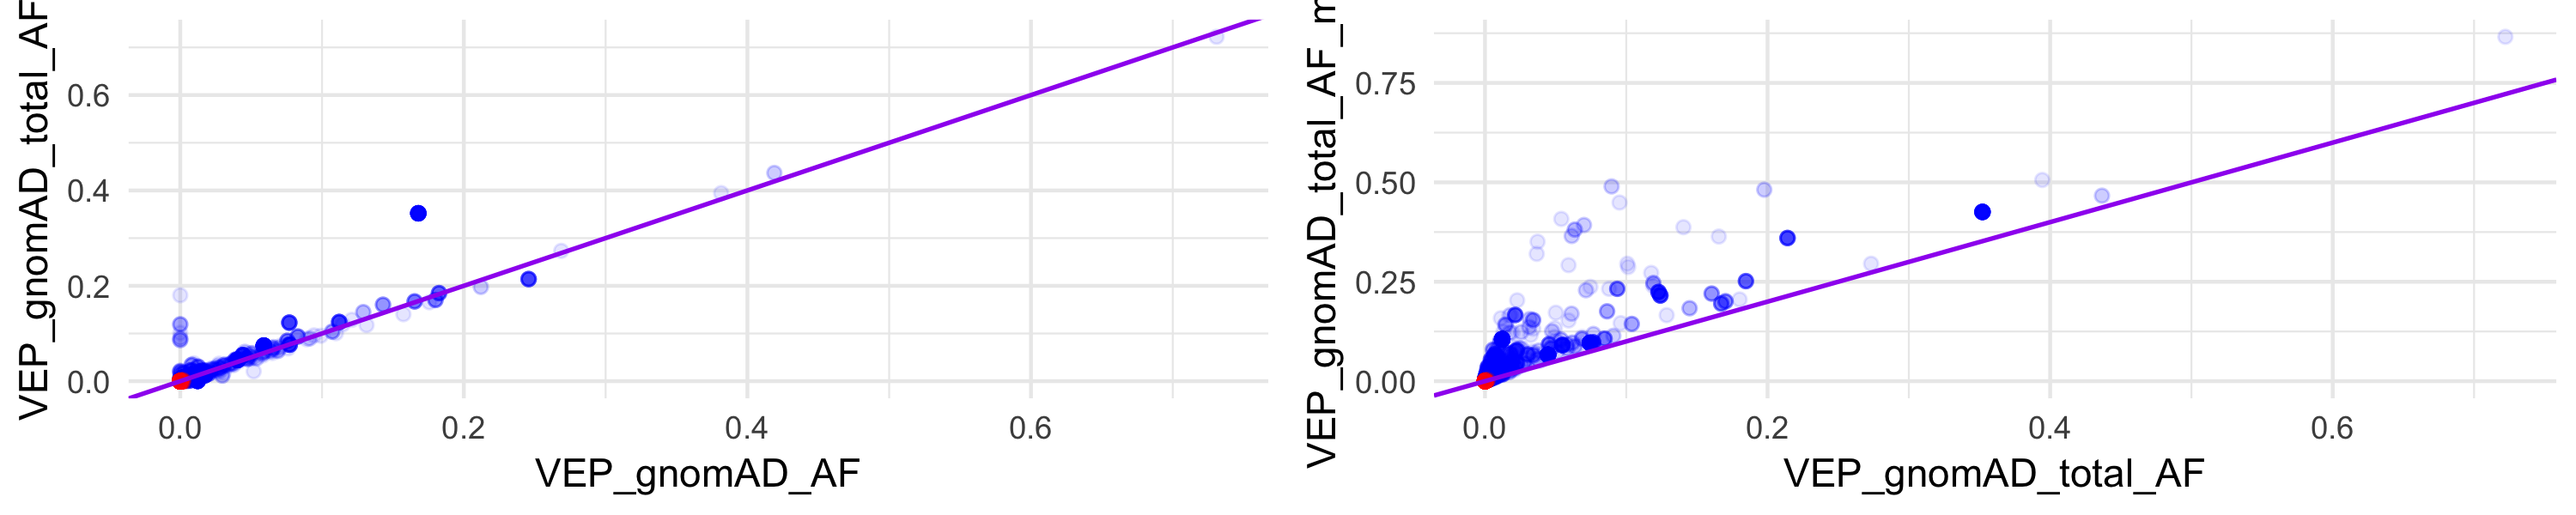

In [246]:
plot1 <- plot_density_2d(impact, "VEP_gnomAD_AF", "VEP_gnomAD_total_AF", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)
plot2 <- plot_density_2d(impact, "VEP_gnomAD_total_AF", "VEP_gnomAD_total_AF_max", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)
plot_side_by_side(plot1, plot2)

We remove the features we won't use, ie:
* `VEP_gnomAD_genome_AC.AN_<POP>`: 7 features
* `VEP_gnomAD_exome_AC.AN_<POP>`: 7 features
* `VEP_gnomAD_total_AC.AN_<POP>`: 7 features

In [247]:
# [-21 features] remove VEP_gnomAD_genome_AC.AN_<POP>, VEP_gnomAD_exome_AC.AN_<POP> and VEP_gnomAD_total_AC.AN_<POP>
impact <- impact[, colnames(impact)[! (grepl("VEP_gnomAD_genome_AC.AN", colnames(impact)) |
                                       grepl("VEP_gnomAD_exome_AC.AN", colnames(impact)) |
                                       grepl("VEP_gnomAD_total_AC.AN", colnames(impact)))]]

In [248]:
vep_gnomad_colnames <- c("VEP_gnomAD_AF",
                         "VEP_gnomAD_total_AF_AFR",
                         "VEP_gnomAD_total_AF_AMR",
                         "VEP_gnomAD_total_AF_ASJ",
                         "VEP_gnomAD_total_AF_EAS",
                         "VEP_gnomAD_total_AF_FIN",
                         "VEP_gnomAD_total_AF_NFE",
                         "VEP_gnomAD_total_AF_OTH",
                         "VEP_gnomAD_total_AF_max",
                         "VEP_gnomAD_total_AF")

### [NEW - Modify] `variant_caller_cv`

Tabre gave by Ahmet:

| `variant_caller_cv` | caller combination   |
| ------------------- | -------------------- |
| 1                   | MUTECT_ANNOVAR       |
| 2                   | SOMATICINDEL_ANNOVAR |
| 3                   | PINDEL_ANNOVAR       |
| 4                   | SID_PINDEL_ANNOVAR   |
| 5                   | UNKNOWN              |
| 6                   | HTC                  |
| 7                   | MutectHTC            |
| 8                   | MUTECT_VARDICT       |
| 9                   | PINDEL_VARDICT       |
| 10                  | SID_PINDEL_VARDICT   |
| 11                  | SID_VARDICT          |
| 12                  | VARDICT              |

In [255]:
variant_caller_table <- c("MUTECT_ANNOVAR",
                          "SOMATICINDEL_ANNOVAR",
                          "PINDEL_ANNOVAR",
                          "SID_PINDEL_ANNOVAR",
                          "UNKNOWN",
                          "HTC",
                          "MutectHTC",
                          "MUTECT_VARDICT",
                          "PINDEL_VARDICT",
                          "SID_PINDEL_VARDICT",
                          "SID_VARDICT",
                          "VARDICT")

dd <- head(unique(impact$variant_caller_cv), 10)
dd <- data.frame(dd, sapply(dd, function(x) variant_caller_table[x]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
1,MUTECT_ANNOVAR
2,SOMATICINDEL_ANNOVAR
3,PINDEL_ANNOVAR
4,SID_PINDEL_ANNOVAR
5,UNKNOWN
12,VARDICT
11,SID_VARDICT
8,MUTECT_VARDICT
9,PINDEL_VARDICT
10,SID_PINDEL_VARDICT


In [257]:
# [~ every rows] variant_caller_cv -> readable variant_caller_cv
impact$variant_caller_cv <- sapply(impact$variant_caller_cv, function(x) variant_caller_table[x])